In [1]:
# ==================================================================
# IMPORT LIBRARIES
# =================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from IPython.display import display #To display dataframe with a nice format.

# Setting display precision for pandas
pd.set_option("display.precision", 2)
# Set display option to show all columns
pd.set_option('display.max_columns', None)

blue_green      = (82/255, 162/255, 160/255)
blue_green_dark = (41/255, 81/255, 81/255)

# ==================================================================================================
# Set the fontsize & Bold for each GRAPH !!!
# ==================================================================================================
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["lines.markersize"] = 10
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams['axes.titlepad'] = 20 

In [2]:
# ==================================================================
# LOAD DATASET
# =================================================================
df = pd.read_csv('../input/customer-personality-analysis/marketing_campaign.csv',sep='\t')
display(df.head(3))

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0


# I. CLEANING + EDA + BASIC FEATURE ENGINEERING

In [3]:
# ==================================================================
# KEEP ONLY RECENT DATA
# =================================================================
print(f"Original dataset size: {df.shape[0]} rows")

# Keep only the rows where Year_Birth > 1949
df = df[df['Year_Birth'] > 1949]

# Display the shape of the filtered DataFrame

print(f"Filtered dataset size: {df.shape[0]} rows")

# ==================================================================
# CORRECTING ANOMALIES
# =================================================================
df = df[df['Income'] <= 120000] # We keep the rowds where income is less than 120 000. We delete few lines !!

# ==================================================================
# Missing Values
# =================================================================
# Check for missing values
display("\nMissing Values:")
missing_values = df.isnull().sum()
display(missing_values)

# Remove rows with any null values
df = df.dropna()

# Display the new shape of the dataset after dropping nulls
print(f"New dataset shape after removing rows with null values: {df.shape}")

# ==================================================================
# FEATURE ENGINEERING
# =================================================================

# 1. Basic Demographics Features
df['Age'] = 2023 - df['Year_Birth']
df['Age_Squared'] = df['Age'] ** 2  # Capture non-linear age effects
df['TotalChildren'] = df['Kidhome'] + df['Teenhome']
df['HasChildren'] = (df['TotalChildren'] > 0).astype(int)
df['ChildrenRatio'] = df['Kidhome'] / (df['TotalChildren'] + 1e-6)  # Ratio of young children

# 2. Spending Patterns
# Total spending and campaign features
df['TotalSpending'] = (df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + 
                      df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds'])
df['TotalAcceptedCampaigns'] = (df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + 
                               df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response'])

# Spending ratios
spending_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 
                   'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
for col in spending_columns:
    df[f'{col}_Ratio'] = df[col] / (df['TotalSpending'] + 1e-6)

# 3. Advanced Spending Metrics
df['AvgSpendingPerProduct'] = df['TotalSpending'] / len(spending_columns)
df['SpendingVariance'] = df[spending_columns].var(axis=1)
df['SpendingSkew'] = df[spending_columns].skew(axis=1)

# Spending categories
df['LuxuryRatio'] = (df['MntWines'] + df['MntGoldProds']) / (df['TotalSpending'] + 1e-6)
df['FreshFoodRatio'] = (df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts']) / (df['TotalSpending'] + 1e-6)

# 4. Income-Related Features
df['Income_Log'] = np.log1p(df['Income'])  # Log transform for better distribution
df['SpendingToIncome'] = df['TotalSpending'] / (df['Income'] + 1e-6)
df['AvgTransactionValue'] = df['TotalSpending'] / (df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] + 1e-6)

# 5. Shopping Behavior
df['TotalPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']
df['WebPurchaseRatio'] = df['NumWebPurchases'] / (df['TotalPurchases'] + 1e-6)
df['CatalogPurchaseRatio'] = df['NumCatalogPurchases'] / (df['TotalPurchases'] + 1e-6)
df['StorePurchaseRatio'] = df['NumStorePurchases'] / (df['TotalPurchases'] + 1e-6)

# 6. Customer Engagement Metrics
df['ComplaintRate'] = df['Complain'] / (df['TotalPurchases'] + 1e-6)
df['AcceptanceRate'] = df['TotalAcceptedCampaigns'] / 6  # 6 total campaigns
df['WebActivityRatio'] = df['NumWebVisitsMonth'] / (df['TotalPurchases'] + 1e-6)

# 7. Time-Based Features
# Convert the 'Dt_Customer' column to datetime format first
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
# Convert the datetime to Unix timestamp (seconds since 1970-01-01)
df['DaysCustomer'] = df['Dt_Customer'].astype(np.int64) // 10**9  # Unix timestamp in seconds
df['DaysCustomer'] = df['Dt_Customer'].astype(np.int64) // 10**9  # Convert to Unix timestamp
df['CustomerTenure'] = (df['DaysCustomer'] - df['DaysCustomer'].min()) / (24 * 60 * 60)  # Convert to days
df['PurchaseFrequency'] = df['TotalPurchases'] / (df['CustomerTenure'] + 1)

# 8. Interaction Features
df['Income_Age_Interaction'] = df['Income'] * df['Age']
df['Income_Children_Interaction'] = df['Income'] * df['TotalChildren']
df['Age_Children_Interaction'] = df['Age'] * df['TotalChildren']

# 9. Customer Value Metrics
df['CustomerLifetimeValue'] = df['TotalSpending'] * (1 + df['AcceptanceRate']) / (df['CustomerTenure'] + 1)
df['EngagementScore'] = (df['AcceptanceRate'] + df['WebActivityRatio'] + 
                        df['TotalPurchases']/(df['TotalPurchases'].max()) - 
                        df['ComplaintRate'])/4

# 10. Product Preference Scores
df['WinePreference'] = df['MntWines_Ratio'] * df['TotalSpending']
df['GoldPreference'] = df['MntGoldProds_Ratio'] * df['TotalSpending']
df['FreshFoodPreference'] = df['FreshFoodRatio'] * df['TotalSpending']


# ==================================================================
# ONE HOT ENCODING FOR CATEGORICAL FEATURES
# =================================================================
from sklearn.preprocessing import LabelEncoder

# Categorical columns
cat_cols = df.select_dtypes(include=['object']).columns

# Encoding categorical features
for col in cat_cols:
        # apply Label Encoding
        print(f"\nLabel Encoding {col}:")
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
display(df.head())  # Show the DataFrame after encoding


Original dataset size: 2240 rows
Filtered dataset size: 2130 rows


'\nMissing Values:'

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64

New dataset shape after removing rows with null values: (2100, 29)

Label Encoding Education:

Label Encoding Marital_Status:


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Age_Squared,TotalChildren,HasChildren,ChildrenRatio,TotalSpending,TotalAcceptedCampaigns,MntWines_Ratio,MntFruits_Ratio,MntMeatProducts_Ratio,MntFishProducts_Ratio,MntSweetProducts_Ratio,MntGoldProds_Ratio,AvgSpendingPerProduct,SpendingVariance,SpendingSkew,LuxuryRatio,FreshFoodRatio,Income_Log,SpendingToIncome,AvgTransactionValue,TotalPurchases,WebPurchaseRatio,CatalogPurchaseRatio,StorePurchaseRatio,ComplaintRate,AcceptanceRate,WebActivityRatio,DaysCustomer,CustomerTenure,PurchaseFrequency,Income_Age_Interaction,Income_Children_Interaction,Age_Children_Interaction,CustomerLifetimeValue,EngagementScore,WinePreference,GoldPreference,FreshFoodPreference
0,5524,1957,2,4,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,66,4356,0,0,0.0,1617,1,0.39,0.05,0.34,0.11,0.05,0.05,269.50,63675.10,0.95,0.45,0.50,10.97,2.78e-02,73.50,22,0.36,0.45,0.18,0.0,0.17,0.32,1346716800,36.0,5.95e-01,3.84e+06,0.0,0,50.99,0.29,635.0,88.0,806.0
1,2174,1954,2,4,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,69,4761,2,1,0.5,27,0,0.41,0.04,0.22,0.07,0.04,0.22,4.50,15.50,0.88,0.63,0.33,10.74,5.83e-04,6.75,4,0.25,0.25,0.50,0.0,0.00,1.25,1394236800,586.0,6.81e-03,3.20e+06,92688.0,138,0.05,0.34,11.0,6.0,9.0
2,4141,1965,2,5,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,58,3364,0,0,0.0,776,0,0.55,0.06,0.16,0.14,0.03,0.05,129.33,22833.87,2.06,0.60,0.37,11.18,1.08e-02,38.80,20,0.40,0.10,0.50,0.0,0.00,0.20,1377043200,387.0,5.15e-02,4.15e+06,0.0,0,2.00,0.21,426.0,42.0,287.0
3,6182,1984,2,5,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,39,1521,1,1,1.0,53,0,0.21,0.08,0.38,0.19,0.06,0.09,8.83,40.57,1.20,0.30,0.64,10.19,1.99e-03,8.83,6,0.33,0.00,0.67,0.0,0.00,1.00,1391990400,560.0,1.07e-02,1.04e+06,26646.0,39,0.09,0.30,11.0,5.0,34.0
4,5324,1981,4,3,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,42,1764,1,1,1.0,422,0,0.41,0.10,0.28,0.11,0.06,0.04,70.33,3818.27,1.15,0.45,0.49,10.97,7.24e-03,30.14,14,0.36,0.21,0.43,0.0,0.00,0.36,1390089600,538.0,2.60e-02,2.45e+06,58293.0,42,0.78,0.20,173.0,15.0,207.0


# II. CLUSTERING

In this section, I will apply multiple clustering methods **(KMEANS and HIERACHICAL CLUSTERING)** and evaluate their performance.  
The **evaluation criteria** will be based on three metrics:
- **Maximizing** the **Silhouette Score** and **Calinski-Harabasz Index**.
- **Minimizing** the **Davies-Bouldin Index**.

The method and initial parameters that achieve the best balance across these metrics will be selected.

In [4]:
# ==================================================================
# CLUSTERING - SELECTION OF FEATURE AND TRANSFORMATION
# =================================================================
# Select features for clustering
features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()


# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

In [5]:
# # ==================================================================
# # CLUSTERING - FEATURES SELECTION 
# # =================================================================

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import kurtosis, skew
import numpy as np

def select_features_for_clustering(df_scaled, feature_names, n_clusters, clustering_method='KMeans', random_state=42, eps=0.5, min_samples=5):
    """
    Perform feature selection for clustering using multiple methods on pre-scaled data.
    
    Parameters:
    -----------
    df_scaled : numpy array
        The pre-scaled input data
    feature_names : list
        List of feature names corresponding to the columns in df_scaled
    n_clusters : int
        Number of clusters for K-means or hierarchical clustering
    clustering_method : str
        Clustering method to use ('KMeans', 'Hierarchical', or 'DBSCAN')
    random_state : int
        Random state for reproducibility
    eps : float
        The maximum distance between two samples for them to be considered as in the same neighborhood (for DBSCAN)
    min_samples : int
        The number of samples in a neighborhood for a point to be considered as a core point (for DBSCAN)
    
    Returns:
    --------
    selected_features : list
        List of selected feature names
    feature_scores : dict
        Dictionary containing importance scores for each feature
    """

    # Check for NaN values in df_scaled
    if np.any(np.isnan(df_scaled)):
        raise ValueError("Input data contains NaN values.")
        
    # 1. Variance-based selection
    variances = np.var(df_scaled, axis=0)
    
    # Handle zero variance
    non_zero_variance_indices = np.where(variances > 0)[0]
    df_scaled = df_scaled[:, non_zero_variance_indices]
    feature_names = [feature_names[i] for i in non_zero_variance_indices]
    
    # 2. Distribution-based metrics
    kurtosis_scores = np.abs(kurtosis(df_scaled, axis=0))
    skewness_scores = np.abs(skew(df_scaled, axis=0))
    
    # 3. Clustering-based feature importance
    feature_importance = np.zeros(len(feature_names))
    
    # Compute base clustering score with all features
    if clustering_method == 'KMeans':
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
        kmeans.fit(df_scaled)
        base_silhouette = silhouette_score(df_scaled, kmeans.labels_)
        base_ch = calinski_harabasz_score(df_scaled, kmeans.labels_)
        base_db = davies_bouldin_score(df_scaled, kmeans.labels_)
    elif clustering_method == 'Hierarchical':
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
        labels = hierarchical.fit_predict(df_scaled)
        base_silhouette = silhouette_score(df_scaled, labels)
        base_ch = calinski_harabasz_score(df_scaled, labels)
        base_db = davies_bouldin_score(df_scaled, labels)
    elif clustering_method == 'DBSCAN':
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_scaled)
        # Only calculate metrics for clusters, ignore noise points (-1)
        if len(set(labels)) > 1:
            base_silhouette = silhouette_score(df_scaled, labels) if len(set(labels) - {-1}) > 1 else -1
            base_ch = calinski_harabasz_score(df_scaled, labels) if len(set(labels) - {-1}) > 1 else -1
            base_db = davies_bouldin_score(df_scaled, labels) if len(set(labels) - {-1}) > 1 else -1
        else:
            base_silhouette, base_ch, base_db = -1, -1, -1
    else:
        raise ValueError("Invalid clustering method specified. Choose 'KMeans', 'Hierarchical', or 'DBSCAN'.")
    
    base_score = (base_silhouette + base_ch/1000 - base_db)/3 if base_db > 0 else -1

    # Calculate feature importance based on score change when feature is removed
    for i in range(len(feature_names)):
        X_reduced = np.delete(df_scaled, i, axis=1)

        if clustering_method == 'KMeans':
            kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
            kmeans.fit(X_reduced)
            sil = silhouette_score(X_reduced, kmeans.labels_)
            ch = calinski_harabasz_score(X_reduced, kmeans.labels_) / 1000
            db = davies_bouldin_score(X_reduced, kmeans.labels_)
        elif clustering_method == 'Hierarchical':
            hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
            labels = hierarchical.fit_predict(X_reduced)
            sil = silhouette_score(X_reduced, labels)
            ch = calinski_harabasz_score(X_reduced, labels)
            db = davies_bouldin_score(X_reduced, labels)
        elif clustering_method == 'DBSCAN':
            labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X_reduced)
            sil = silhouette_score(X_reduced, labels) if len(set(labels) - {-1}) > 1 else -1
            ch = calinski_harabasz_score(X_reduced, labels) if len(set(labels) - {-1}) > 1 else -1
            db = davies_bouldin_score(X_reduced, labels) if len(set(labels) - {-1}) > 1 else -1
        else:
            raise ValueError("Invalid clustering method specified. Choose 'KMeans', 'Hierarchical', or 'DBSCAN'.")

        score = (sil + ch - db) / 3 if db > 0 else -1
        
        # If score decreases when feature is removed, feature is important
        feature_importance[i] = base_score - score if base_score != -1 else 0
    
    # Combine all metrics into a single importance score
    feature_scores = {}
    for i, feature in enumerate(feature_names):
        importance = (
            0.3 * (variances[i] / np.max(variances)) +  # Variance
            0.3 * (feature_importance[i] / np.max(feature_importance)) +  # Clustering importance
            0.2 * (1 - kurtosis_scores[i] / np.max(kurtosis_scores)) +  # Kurtosis (inverse)
            0.2 * (1 - skewness_scores[i] / np.max(skewness_scores))    # Skewness (inverse)
        )
        feature_scores[feature] = importance
    
    # Select features based on importance threshold
    threshold = np.mean(list(feature_scores.values())) + 0.5 * np.std(list(feature_scores.values()))
    selected_features = [f for f, score in feature_scores.items() if score > threshold]
    
    return selected_features, feature_scores

<div style="background-color:#b6d7a8; padding: 15px;">

## NOTE 1 : Clustering Validation Metrics

### 1. Silhouette Score:
This measures how similar an object is to its own cluster compared to other clusters.  
It ranges from **-1 to 1**, where:
- **1** indicates well-separated clusters.
- **0** indicates overlapping clusters.
- **-1** suggests that the points are in the wrong cluster.

> A higher silhouette score indicates better-defined clusters, with values close to 1 being desirable.

### 2. Calinski-Harabasz Index (Variance Ratio Criterion):
This metric evaluates the ratio of the sum of between-cluster dispersion to within-cluster dispersion.
- A **higher score** indicates better-defined clusters.
- There's no fixed upper limit, but **higher values** suggest more compact and well-separated clusters.

### 3. Davies-Bouldin Index:
This measures the average similarity ratio between each cluster and the cluster most similar to it.  
It ranges from **0 to infinity**, where:
- **0** indicates perfect clustering.
- A **lower score** is better, as it suggests that clusters are well-separated and compact.

### Mini Conclusion:
For these metrics, a **good score** depends on the context and data:
- **Silhouette Score** should ideally be close to **1**.
- **Calinski-Harabasz** should be as **high** as possible.
- **Davies-Bouldin** should be as **low** as possible.

</div>

<div style="background-color:#b6d7a8; padding: 15px;">

## NOTE 2: Feature Selection and Clustering Validation

### 1. **Variance-Based Feature Selection**:
This method selects features based on their variance.  
- **Zero variance** features are removed as they do not contribute to clustering. 
- Higher variance generally indicates more informative features.

> **Note**: Removing features with zero variance ensures that only features with variability are considered, making the clustering process more meaningful.

### 2. **Distribution-Based Metrics**:
We evaluate two distribution characteristics for each feature:
- **Kurtosis**: Measures the "tailedness" of the feature's distribution.  
  - Extreme kurtosis values may suggest outliers or heavy tails.
  - Features with more "normal" kurtosis values (closer to 0) are preferred.
  
- **Skewness**: Measures the asymmetry of the feature's distribution.  
  - Highly skewed features may distort clustering results.  
  - Features with lower skewness (closer to 0) are considered more balanced.

> **Note**: These metrics help in identifying features that are too extreme or unbalanced, which could negatively impact clustering.

### 3. **Clustering-Based Feature Importance**:
This step measures each feature’s importance based on how clustering performance changes when the feature is removed.
- **Silhouette Score**, **Calinski-Harabasz Score**, and **Davies-Bouldin Index** are recalculated after removing each feature.  
  - If removing a feature worsens these scores, the feature is deemed important.
  
> **Note**: Features that contribute positively to clustering quality are retained, while those that have little impact are discarded.

### 4. **Combining Feature Scores**:
We combine variance, kurtosis, skewness, and clustering importance into a final score for each feature:
- **Variance and Clustering Importance** are weighted more heavily (0.3 each).
- **Kurtosis and Skewness** contribute less (0.2 each).

A feature is selected if its combined score exceeds a calculated threshold based on the mean and standard deviation of all feature scores.

### Mini Conclusion:
This method ensures that only the most **informative** and **balanced** features are used for clustering. The selected features are those that maximize variance, contribute significantly to clustering quality, and have reasonable kurtosis and skewness values.

</div>


## II.1. CLUSTERING - KMEAN

<div style="background-color:#b6d7a8; padding: 15px;">
    
## NOTE 3: K-Means Clustering Algorithm

K-Means is a popular unsupervised machine learning algorithm used for partitioning a dataset into **K distinct clusters**. Here's a brief overview of how it works:

### Steps of the K-Means Algorithm:
  
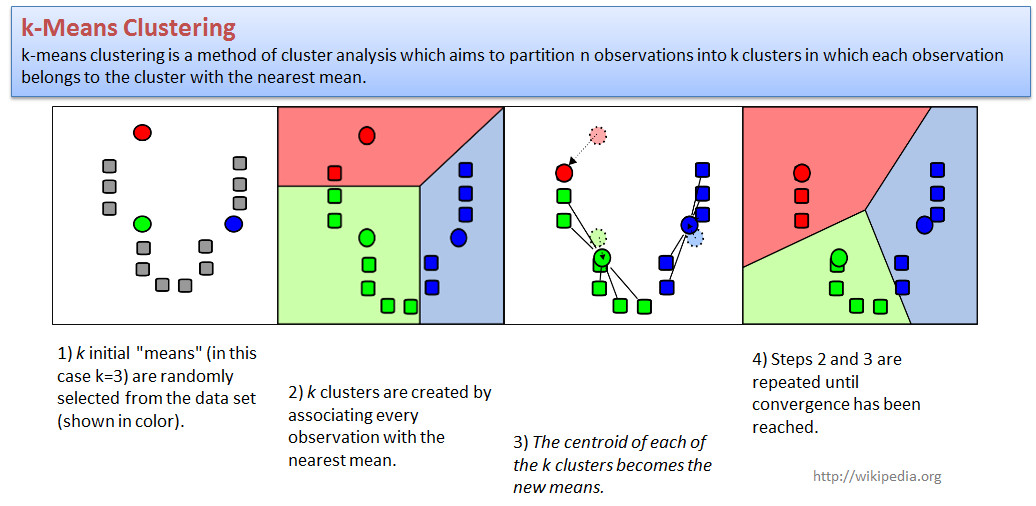
    
1. **Initialization**: 
   - Choose the number of clusters **K**.
   - Randomly select **K** initial centroids from the dataset.

2. **Assignment Step**:
   - For each data point, calculate the distance to each centroid.
   - Assign each data point to the nearest centroid, forming **K clusters**.

3. **Update Step**:
   - Recalculate the centroids of each cluster by taking the mean of all data points assigned to that cluster.

4. **Repeat**:
   - Repeat the **Assignment** and **Update** steps until the centroids no longer change significantly or until a specified number of iterations is reached.

### Key Characteristics:

- **Distance Metric**: K-Means typically uses the Euclidean distance to measure the distance between points and centroids.
- **Convergence**: The algorithm converges when the centroids stabilize, meaning that the assignments of data points to clusters do not change.
- **Scalability**: K-Means is efficient and can handle large datasets, but the choice of **K** can significantly impact the results.

### Limitations:

- **Choosing K**: The optimal number of clusters must be determined beforehand, which can be challenging.
- **Sensitivity to Initial Centroids**: Different initializations can lead to different results, so it's common to run the algorithm multiple times with different initial centroids.
- **Assumes Spherical Clusters**: K-Means assumes that clusters are spherical and evenly sized, which may not hold true for all datasets.

K-Means is widely used for tasks such as customer segmentation, image compression, and pattern recognition.
    


</div>

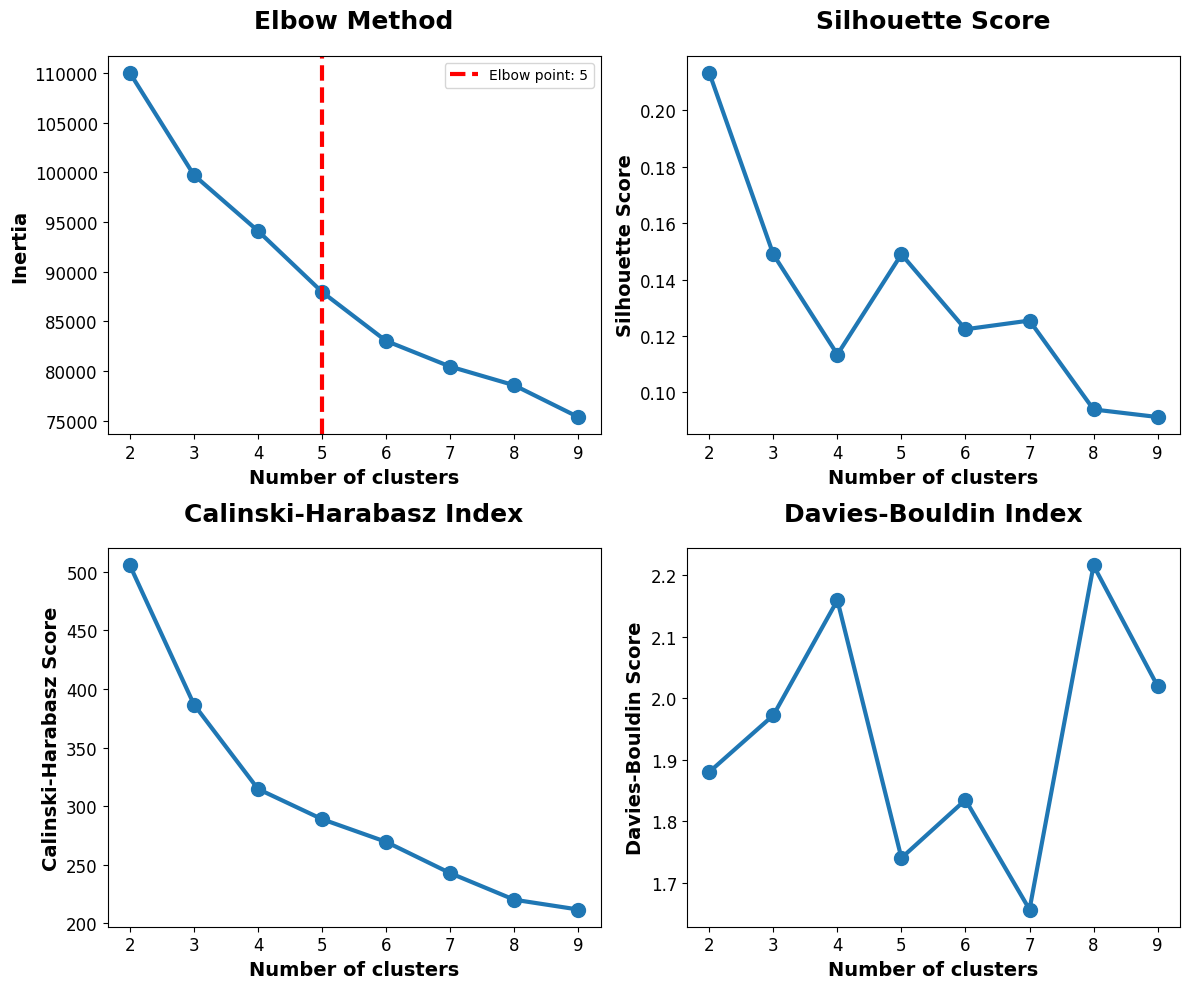

Optimal number of clusters: 5


In [6]:
# ==================================================================
# SELECT THE NUMBER OF CLUSTER TO INVESTIGATE USING THE ELBOW METHOD
# =================================================================
!pip install kneed
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from kneed import KneeLocator

# Method 1: Elbow Method
inertias = []
silhouette_scores = []
ch_scores = []
db_scores = []

max_clusters = 9
for k in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))
    ch_scores.append(calinski_harabasz_score(df_scaled, kmeans.labels_))
    db_scores.append(davies_bouldin_score(df_scaled, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(12, 10))
plt.subplot(221)
plt.plot(range(2, max_clusters+1), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Find the elbow point
kl = KneeLocator(range(2, max_clusters+1), inertias, curve="convex", direction="decreasing")
elbow_point = kl.elbow
plt.axvline(x=elbow_point, color='r', linestyle='--', label=f'Elbow point: {elbow_point}')
plt.legend()

# Plot Silhouette Scores
plt.subplot(222)
plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

# Plot Calinski-Harabasz Index
plt.subplot(223)
plt.plot(range(2, max_clusters+1), ch_scores, marker='o')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Score')


# Plot Davies-Bouldin Index
plt.subplot(224)
plt.plot(range(2, max_clusters+1), db_scores, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Score')

plt.tight_layout()
plt.show()

# Select optimal number of clusters
optimal_clusters = elbow_point
print(f"Optimal number of clusters: {optimal_clusters}")

In [7]:
# ==================================================================
# CLUSTERING - FEATURE SELECTION + VALIDATION
# =================================================================
selected_features_KMEANS, feature_scores = select_features_for_clustering(
    df_scaled,
    feature_names=features, 
    n_clusters=optimal_clusters, 
    clustering_method='KMeans', 
    random_state=42, 
    eps=0.5, # if method is DBSCAN
    min_samples=5 # if method is DBSCAN
) 
    
# Create a DataFrame for feature importance scores
feature_importance_df = pd.DataFrame(
    list(feature_scores.items()), 
    columns=['Feature', 'Importance Score']
)

# Sort the DataFrame by Importance Score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance Score', ascending=False)

# Display the DataFrame
print("\nFeature Importance Scores:")
display(feature_importance_df)

# Get indices of selected features
selected_indices = [features.index(f) for f in selected_features_KMEANS]
df_scaled_selected_KMEANS = df_scaled[:, selected_indices]

# Perform clustering with selected features
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['Cluster'] = final_kmeans.fit_predict(df_scaled_selected_KMEANS)

# Evaluate final clustering
final_silhouette = silhouette_score(df_scaled_selected_KMEANS, df['Cluster'])
final_ch = calinski_harabasz_score(df_scaled_selected_KMEANS, df['Cluster'])
final_db = davies_bouldin_score(df_scaled_selected_KMEANS, df['Cluster'])

print("\nClustering Metrics with Selected Features:")
print(f"Final Silhouette Score: {final_silhouette:.4f}")
print(f"Final Calinski-Harabasz Score: {final_ch:.4f}")
print(f"Final Davies-Bouldin Score: {final_db:.4f}")


Feature Importance Scores:


,Feature,Importance Score
43,FreshFoodRatio,1.00
58,Income_Children_Interaction,0.99
59,Age_Children_Interaction,0.99
28,TotalChildren,0.99
17,NumStorePurchases,0.98
...,...,...
56,PurchaseFrequency,0.59
51,ComplaintRate,0.56
25,Response,0.43
26,Age,0.40


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Clustering Metrics with Selected Features:
Final Silhouette Score: 0.3746
Final Calinski-Harabasz Score: 1303.4312
Final Davies-Bouldin Score: 1.0398


In [8]:
# ==================================================================
# CLUSTER ANALYSIS
# =================================================================
cluster_means = df.groupby('Cluster')[features].mean()
print("\nCluster Means:")
display(cluster_means)


Cluster Means:


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Age_Squared,TotalChildren,HasChildren,ChildrenRatio,TotalSpending,TotalAcceptedCampaigns,MntWines_Ratio,MntFruits_Ratio,MntMeatProducts_Ratio,MntFishProducts_Ratio,MntSweetProducts_Ratio,MntGoldProds_Ratio,AvgSpendingPerProduct,SpendingVariance,SpendingSkew,LuxuryRatio,FreshFoodRatio,Income_Log,SpendingToIncome,AvgTransactionValue,TotalPurchases,WebPurchaseRatio,CatalogPurchaseRatio,StorePurchaseRatio,ComplaintRate,AcceptanceRate,WebActivityRatio,DaysCustomer,CustomerTenure,PurchaseFrequency,Income_Age_Interaction,Income_Children_Interaction,Age_Children_Interaction,CustomerLifetimeValue,EngagementScore,WinePreference,GoldPreference,FreshFoodPreference
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5609.82,1965.69,2.47,3.72,44424.77,1.07e+00,1.04,50.52,127.46,7.34,50.65,10.36,7.76,23.91,3.57,3.13,0.99,4.09,6.35,0.07,0.04,7.01e-03,9.35e-03,4.67e-03,1.64e-02,3.0,11.0,0.11,57.31,3359.01,2.11e+00,1.00e+00,5.06e-01,227.49,0.23,0.53,0.03,0.23,0.05,0.03,0.14,37.92,7671.80,1.41,0.66,0.30,10.64,4.43e-03,21048.28,8.21,0.35,0.10,0.55,2.66e-03,0.04,44393.60,1.38e+09,363.79,0.10,2.54e+06,93898.02,121.12,3.58,11098.47,127.46,23.91,68.36
1,5540.53,1970.97,2.35,3.78,76176.41,2.82e-03,0.00,50.49,629.83,65.46,492.03,96.17,65.92,77.17,1.07,4.83,6.41,8.91,2.59,0.09,0.14,2.96e-01,2.39e-01,4.23e-02,5.63e-03,3.0,11.0,0.32,52.03,2864.60,2.82e-03,2.82e-03,2.82e-03,1426.59,1.12,0.43,0.05,0.34,0.07,0.05,0.06,237.77,93063.60,1.32,0.49,0.46,11.22,2.07e-02,72.44,20.15,0.24,0.32,0.44,2.27e-04,0.19,0.13,1.37e+09,337.15,0.23,3.97e+06,6.89,0.12,18.11,0.24,629.83,77.17,653.66
2,5567.75,1965.37,2.51,3.67,59478.48,5.48e-02,0.97,48.38,449.59,28.82,145.80,40.39,30.56,58.12,2.78,5.68,3.33,7.56,5.21,0.06,0.13,3.54e-02,4.19e-02,1.61e-02,6.44e-03,3.0,11.0,0.08,57.63,3398.77,1.02e+00,1.00e+00,5.48e-02,753.28,0.36,0.60,0.04,0.19,0.05,0.04,0.09,125.55,45078.10,1.76,0.69,0.27,10.97,1.20e-02,42.25,16.56,0.34,0.19,0.47,3.76e-04,0.06,0.39,1.37e+09,327.70,0.17,3.42e+06,60945.90,59.01,9.88,0.24,449.59,58.12,215.01
3,5505.19,1972.34,2.15,3.65,44599.19,0.00e+00,0.00,47.45,222.49,31.85,169.37,42.89,32.42,46.10,1.30,3.44,1.83,4.41,5.20,0.05,0.03,7.32e-02,6.34e-02,1.46e-02,4.88e-03,3.0,11.0,0.19,50.66,2734.20,0.00e+00,0.00e+00,0.00e+00,545.11,0.43,0.30,0.08,0.26,0.12,0.08,0.16,90.85,25384.48,1.02,0.46,0.46,10.52,9.74e-03,68337.37,9.68,0.33,0.16,0.50,1.63e-03,0.07,165854.53,1.37e+09,348.81,0.07,2.28e+06,0.00,0.00,4.23,41463.73,222.49,46.10,244.10
4,5666.01,1977.96,2.14,3.71,30675.20,9.57e-01,0.06,48.93,39.58,7.55,31.82,10.24,7.04,18.59,2.08,2.45,0.53,3.20,6.90,0.09,0.00,0.00e+00,0.00e+00,0.00e+00,1.02e-02,3.0,11.0,0.12,45.04,2077.96,1.02e+00,1.00e+00,9.46e-01,114.81,0.22,0.29,0.07,0.27,0.10,0.07,0.19,19.14,1089.78,0.84,0.48,0.45,10.25,3.63e-03,10198.11,6.19,0.36,0.07,0.56,2.35e-03,0.04,28514.62,1.37e+09,351.37,0.06,1.39e+06,31022.59,45.91,1.68,7128.71,39.58,18.59,49.60


In [9]:
# ==================================================================
# CLUSTER VISUALISATION (DIMENSIONALITY REDUCTION USING PCA)
# =================================================================
from sklearn.decomposition import PCA
import plotly.express as px


# Visualize clusters using PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_scaled_selected_KMEANS)

# Calculate the total explained variance by the first three components
total_variance = sum(pca.explained_variance_ratio_[:3]) * 100

# Convert the 'Cluster' column to a categorical type with updated names
df['Cluster'] = pd.Categorical(df['Cluster'])


# Create a DataFrame for Plotly visualization
df_pca = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'PC3': pca_result[:, 2],
    'Cluster': df['Cluster']
})

# Define a professional color palette and marker style
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#7f7f7f', '#8c564b']  # Adding distinct colors

marker_style = dict(size=8, opacity=1, line=dict(width=1, color='DarkSlateGrey'))  # Size, transparency, and border

# Create an interactive 3D scatter plot using Plotly
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', color='Cluster', 
                    color_discrete_sequence=color_palette,  # Custom colors
                    title=f'Customer Segments Visualization (Total Variance: {total_variance:.2f}%)',
                    labels={'PC1': 'First Principal Component', 
                            'PC2': 'Second Principal Component', 
                            'PC3': 'Third Principal Component'},
                    template="plotly_white")  # Professional looking template

# Update the marker style
fig.update_traces(marker=marker_style)

# Improve layout with a clean background, larger title, and font adjustments
fig.update_layout(scene=dict(
    xaxis_title='PC1 (First Principal Component)',
    yaxis_title='PC2 (Second Principal Component)',
    zaxis_title='PC3 (Third Principal Component)'),
    title_font_size=25,
    font=dict(family="Arial", size=18),
    legend_title_text='Customer Clusters',
    legend=dict(title=dict(font=dict(size=18))),
    width=1400,  # Set the desired width of the plot
    height=1400   # Set the desired height of the plot
)

# Display the plot
fig.show()

In [10]:
from sklearn.manifold import TSNE
import pandas as pd
import plotly.express as px

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=3, random_state=42, perplexity=30)  # Adjust perplexity if needed
tsne_result = tsne.fit_transform(df_scaled_selected_KMEANS)

# Convert the 'Cluster' column to a categorical type with updated names
df['Cluster'] = pd.Categorical(df['Cluster'])

# Create a DataFrame for Plotly visualization
df_tsne = pd.DataFrame({
    'TSNE1': tsne_result[:, 0],
    'TSNE2': tsne_result[:, 1],
    'TSNE3': tsne_result[:, 2],
    'Cluster': df['Cluster']
})

# Define a professional color palette and marker style
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#7f7f7f', '#8c564b']  # Adding distinct colors
marker_style = dict(size=8, opacity=1, line=dict(width=1, color='DarkSlateGrey'))  # Size, transparency, and border

# Create an interactive 3D scatter plot using Plotly
fig = px.scatter_3d(df_tsne, x='TSNE1', y='TSNE2', z='TSNE3', color='Cluster',
                    color_discrete_sequence=color_palette,  # Custom colors
                    title='Customer Segments Visualization (t-SNE)',
                    labels={'TSNE1': 't-SNE Component 1',
                            'TSNE2': 't-SNE Component 2',
                            'TSNE3': 't-SNE Component 3'},
                    template="plotly_white")  # Professional looking template

# Update the marker style
fig.update_traces(marker=marker_style)

# Improve layout with a clean background, larger title, and font adjustments
fig.update_layout(scene=dict(
    xaxis_title='t-SNE Component 1',
    yaxis_title='t-SNE Component 2',
    zaxis_title='t-SNE Component 3'),
    title_font_size=25,
    font=dict(family="Arial", size=18),
    legend_title_text='Customer Clusters',
    legend=dict(title=dict(font=dict(size=18))),
    width=1400,  # Set the desired width of the plot
    height=1400   # Set the desired height of the plot
)

# Display the plot
fig.show()


## II.2 CLUSTERING - Hierarchical clustering

<div style="background-color:#b6d7a8; padding: 15px;">
    
## NOTE 4: Hierarchical Clustering Algorithm

Hierarchical clustering is a powerful unsupervised machine learning algorithm used for building a hierarchy of clusters by either **merging smaller clusters** (agglomerative approach) or **splitting larger clusters** (divisive approach).

### Types of Hierarchical Clustering:
1. **Agglomerative Clustering (Bottom-Up)**:
   - Starts with each data point as an individual cluster.
   - Merges the closest clusters step by step until only one cluster remains.

2. **Divisive Clustering (Top-Down)**:
   - Starts with all data points in one cluster.
   - Recursively splits clusters until each data point is in its own cluster.

### Steps of Agglomerative Hierarchical Clustering:
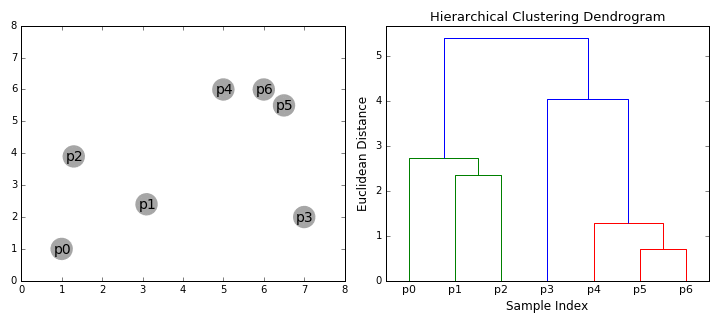
    
1. **Initialization**: 
   - Start with each data point as its own cluster (i.e., if there are **N** data points, you begin with **N** clusters).

2. **Calculate Distance**:
   - Compute the distance (or similarity) between each pair of clusters using a distance metric like **Euclidean** distance.

3. **Merge Clusters**:
   - Identify the two closest clusters and merge them into a single cluster.

4. **Update Distance Matrix**:
   - Update the distance matrix to reflect the distance between the new cluster and the remaining clusters. Different linkage methods (e.g., **single**, **complete**, or **average**) can be used to determine how to compute the distance between clusters.

5. **Repeat**:
   - Repeat the process of merging the closest clusters and updating the distance matrix until only a single cluster remains or a specified number of clusters is achieved.

### Key Characteristics:

- **Dendrogram**: The results of hierarchical clustering are usually presented as a **dendrogram**, which visually represents the hierarchy of clusters.
- **No Need to Predefine K**: Unlike K-Means, you don't need to specify the number of clusters in advance.
- **Linkage Criteria**: The way distances between clusters are calculated can vary:
  - **Single Linkage**: Distance between the closest points in two clusters.
  - **Complete Linkage**: Distance between the farthest points in two clusters.
  - **Average Linkage**: Average distance between all pairs of points in two clusters.
  
  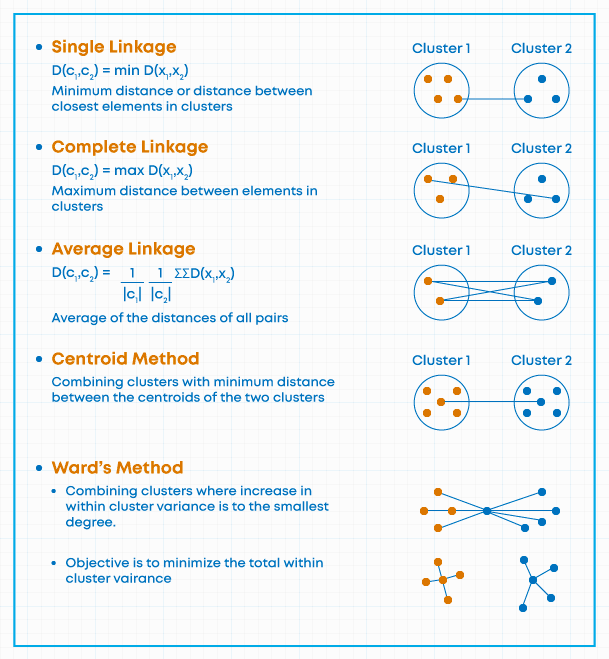
    
### Limitations:

- **Scalability**: Hierarchical clustering can be computationally expensive, especially with large datasets.
- **Irreversible Merging**: Once two clusters are merged, they cannot be split, which may lead to suboptimal clustering if early merges are poorly chosen.

Hierarchical clustering is commonly used in biological taxonomy, social network analysis, and document clustering.
    
</div>



Feature Importance Scores:


,Feature,Importance Score
0,ID,1.03
2,Education,1.03
43,FreshFoodRatio,1.03
48,WebPurchaseRatio,1.03
7,Recency,1.03
...,...,...
61,EngagementScore,0.77
46,AvgTransactionValue,0.76
25,Response,0.71
26,Age,0.70


/tmp/ipykernel_1149/755277543.py:41: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



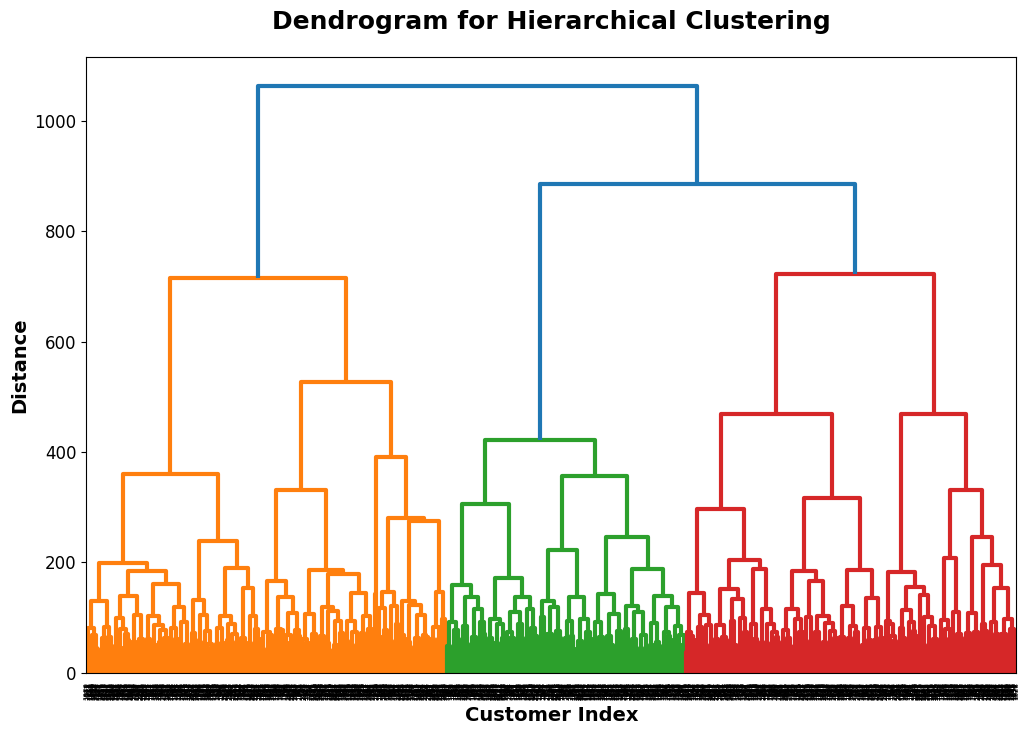

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead




Cluster Means (Hierarchical):


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Age_Squared,TotalChildren,HasChildren,ChildrenRatio,TotalSpending,TotalAcceptedCampaigns,MntWines_Ratio,MntFruits_Ratio,MntMeatProducts_Ratio,MntFishProducts_Ratio,MntSweetProducts_Ratio,MntGoldProds_Ratio,AvgSpendingPerProduct,SpendingVariance,SpendingSkew,LuxuryRatio,FreshFoodRatio,Income_Log,SpendingToIncome,AvgTransactionValue,TotalPurchases,WebPurchaseRatio,CatalogPurchaseRatio,StorePurchaseRatio,ComplaintRate,AcceptanceRate,WebActivityRatio,DaysCustomer,CustomerTenure,PurchaseFrequency,Income_Age_Interaction,Income_Children_Interaction,Age_Children_Interaction,CustomerLifetimeValue,EngagementScore,WinePreference,GoldPreference,FreshFoodPreference
Hierarchical_Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5289.69,1969.78,2.63,3.73,43529.65,0.66,0.57,50.20,150.45,8.78,56.76,13.83,10.07,24.55,2.12,3.17,1.23,3.92,5.66,0.08,6.21e-02,0.03,3.02e-02,0.01,5.03e-03,3.0,11.0,0.08,53.22,2940.35,1.23,0.88,0.48,264.45,0.30,0.48,0.04,0.23,0.07,0.04,0.13,44.08,12707.58,1.35,0.62,0.34,10.59,5.02e-03,22.86,8.33,0.36,0.11,0.53,9.95e-04,0.05,1.01,1.39e+09,528.60,0.02,2.37e+06,51076.67,67.20,0.64,0.33,150.45,24.55,79.38
1,5708.56,1969.24,2.43,3.78,70710.68,0.12,0.40,40.03,492.81,53.00,347.61,71.92,50.51,63.55,1.70,4.91,5.01,8.75,3.11,0.08,7.81e-02,0.16,1.53e-01,0.02,3.00e-03,3.0,11.0,0.16,53.76,3018.56,0.52,0.46,0.10,1079.41,0.65,0.46,0.05,0.31,0.07,0.05,0.07,179.90,62611.46,1.39,0.52,0.43,11.14,1.68e-02,57.46,18.67,0.26,0.26,0.48,1.31e-04,0.11,0.20,1.39e+09,486.67,0.04,3.79e+06,32740.99,28.68,2.80,0.22,492.81,63.55,472.53
2,5431.47,1974.46,1.35,3.54,33284.21,0.68,0.33,49.53,60.05,13.79,54.55,19.58,14.72,24.55,2.15,2.37,0.88,3.41,6.68,0.07,2.98e-03,0.01,2.98e-03,0.00,8.93e-03,3.0,11.0,0.10,48.54,2466.32,1.01,0.78,0.57,187.24,0.19,0.25,0.09,0.26,0.12,0.09,0.20,31.21,3571.82,0.83,0.45,0.46,10.28,4.62e-03,83353.13,6.66,0.31,0.10,0.58,2.41e-03,0.03,199406.10,1.37e+09,266.77,0.10,1.66e+06,35679.07,50.86,3.66,49851.58,60.05,24.55,87.92
3,5562.44,1968.90,2.37,3.71,68018.25,0.11,0.50,52.15,590.54,55.71,349.72,79.20,55.78,77.78,2.58,5.56,4.90,9.67,4.27,0.06,1.16e-01,0.15,1.03e-01,0.02,1.32e-02,3.0,11.0,0.22,54.10,3048.01,0.61,0.53,0.07,1208.73,0.67,0.49,0.05,0.28,0.07,0.05,0.07,201.46,73426.01,1.45,0.56,0.39,11.11,1.75e-02,60.84,20.14,0.27,0.24,0.49,6.48e-04,0.11,0.22,1.36e+09,186.75,0.33,3.67e+06,38580.52,34.21,22.83,0.24,590.54,77.78,484.64
4,6028.12,1968.49,2.67,3.75,45540.91,0.57,0.67,51.94,273.98,12.99,81.23,19.18,15.21,41.26,3.05,4.51,1.87,4.44,6.68,0.07,8.97e-02,0.03,4.16e-02,0.02,1.53e-02,3.0,11.0,0.19,54.51,3079.98,1.24,0.87,0.39,443.86,0.44,0.54,0.03,0.19,0.05,0.04,0.14,73.98,27735.26,1.52,0.68,0.28,10.65,8.19e-03,32.05,10.82,0.40,0.14,0.46,2.73e-03,0.07,0.88,1.36e+09,187.27,0.20,2.51e+06,55479.76,68.82,10.11,0.32,273.98,41.26,113.40



Clustering Metrics with Selected Features:
Final Silhouette Score: 0.0729
Final Calinski-Harabasz Score: 189.6631
Final Davies-Bouldin Score: 2.5806


In [11]:
# ==================================================================
# CLUSTERING - FEATURE SELECTION + VALIDATION
# =================================================================
selected_features_HIERARCHICAL, feature_scores = select_features_for_clustering(
    df_scaled,
    feature_names=features, 
    n_clusters=optimal_clusters, 
    clustering_method='Hierarchical', 
    random_state=42, 
    eps=0.5, # if method is DBSCAN
    min_samples=5 # if method is DBSCAN
) 
    
# Create a DataFrame for feature importance scores
feature_importance_df = pd.DataFrame(
    list(feature_scores.items()), 
    columns=['Feature', 'Importance Score']
)

# Sort the DataFrame by Importance Score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance Score', ascending=False)

# Display the DataFrame
print("\nFeature Importance Scores:")
display(feature_importance_df)

# Get indices of selected features
selected_indices = [features.index(f) for f in selected_features_HIERARCHICAL]
df_scaled_selected_HIERARCHICAL = df_scaled[:, selected_indices]



from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

# Step 2: Create a distance matrix
distance_matrix = pairwise_distances(df_scaled_selected_HIERARCHICAL, metric='euclidean')

# Step 3: Perform Hierarchical Clustering and create a linkage matrix
linkage_matrix = hierarchy.linkage(distance_matrix, method='ward')

# Step 4: Visualize the Dendrogram
plt.figure(figsize=(12, 8))
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Customer Index')
plt.ylabel('Distance')
plt.show()

# Step 5: Assign clusters
# You can decide how many clusters to cut from the dendrogram
n_clusters = optimal_clusters  # based on optimal clusters from KMEAN, so we can compare them. 
hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
df['Hierarchical_Cluster'] = hierarchical_clustering.fit_predict(df_scaled_selected_HIERARCHICAL)

# Step 6: Analyze clusters
cluster_means_hierarchical = df.groupby('Hierarchical_Cluster')[features].mean()
print("\nCluster Means (Hierarchical):")
display(cluster_means_hierarchical)



# Evaluate final clustering
final_silhouette = silhouette_score(df_scaled_selected_HIERARCHICAL, df['Hierarchical_Cluster'])
final_ch = calinski_harabasz_score(df_scaled_selected_HIERARCHICAL, df['Hierarchical_Cluster'])
final_db = davies_bouldin_score(df_scaled_selected_HIERARCHICAL, df['Hierarchical_Cluster'])

print("\nClustering Metrics with Selected Features:")
print(f"Final Silhouette Score: {final_silhouette:.4f}")
print(f"Final Calinski-Harabasz Score: {final_ch:.4f}")
print(f"Final Davies-Bouldin Score: {final_db:.4f}")

In [12]:
# ==================================================================
# CLUSTER VISUALISATION (DIMENSIONALITY REDUCTION USING PCA)
# =================================================================
from sklearn.decomposition import PCA
import plotly.express as px


# Visualize clusters using PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_scaled_selected_HIERARCHICAL)

# Calculate the total explained variance by the first three components
total_variance = sum(pca.explained_variance_ratio_[:3]) * 100

# Convert the 'Cluster' column to a categorical type with updated names
df['Hierarchical_Cluster'] = pd.Categorical(df['Hierarchical_Cluster'])


# Create a DataFrame for Plotly visualization
df_pca = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'PC3': pca_result[:, 2],
    'Cluster': df['Hierarchical_Cluster']
})

# Define a professional color palette and marker style
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#7f7f7f', '#8c564b']  # Adding distinct colors

marker_style = dict(size=8, opacity=1, line=dict(width=1, color='DarkSlateGrey'))  # Size, transparency, and border

# Create an interactive 3D scatter plot using Plotly
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', color='Cluster', 
                    color_discrete_sequence=color_palette,  # Custom colors
                    title=f'Customer Segments Visualization (Total Variance: {total_variance:.2f}%)',
                    labels={'PC1': 'First Principal Component', 
                            'PC2': 'Second Principal Component', 
                            'PC3': 'Third Principal Component'},
                    template="plotly_white")  # Professional looking template

# Update the marker style
fig.update_traces(marker=marker_style)

# Improve layout with a clean background, larger title, and font adjustments
fig.update_layout(scene=dict(
    xaxis_title='PC1 (First Principal Component)',
    yaxis_title='PC2 (Second Principal Component)',
    zaxis_title='PC3 (Third Principal Component)'),
    title_font_size=25,
    font=dict(family="Arial", size=18),
    legend_title_text='Customer Clusters',
    legend=dict(title=dict(font=dict(size=18))),
    width=1400,  # Set the desired width of the plot
    height=1400   # Set the desired height of the plot
)

# Display the plot
fig.show()

# III. COMPARISON BETWEEN CLUSTERING

In [13]:
# ==================================================================
# COMPARISON BETWEEN CLUSTERING METHODS
# =================================================================
# Evaluate KMeans
kmeans_silhouette = silhouette_score(df_scaled_selected_KMEANS, df['Cluster'])
kmeans_ch = calinski_harabasz_score(df_scaled_selected_KMEANS, df['Cluster'])
kmeans_db = davies_bouldin_score(df_scaled_selected_KMEANS, df['Cluster'])

# Evaluate Hierarchical Clustering
hierarchical_silhouette = silhouette_score(df_scaled_selected_HIERARCHICAL, df['Hierarchical_Cluster'])
hierarchical_ch = calinski_harabasz_score(df_scaled_selected_HIERARCHICAL, df['Hierarchical_Cluster'])
hierarchical_db = davies_bouldin_score(df_scaled_selected_HIERARCHICAL, df['Hierarchical_Cluster'])

# Print results
print("KMeans Clustering Metrics:")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Calinski-Harabasz Score: {kmeans_ch:.4f}")
print(f"Davies-Bouldin Score: {kmeans_db:.4f}")

print("\nHierarchical Clustering Metrics:")
print(f"Silhouette Score: {hierarchical_silhouette:.4f}")
print(f"Calinski-Harabasz Score: {hierarchical_ch:.4f}")
print(f"Davies-Bouldin Score: {hierarchical_db:.4f}")

KMeans Clustering Metrics:
Silhouette Score: 0.3746
Calinski-Harabasz Score: 1303.4312
Davies-Bouldin Score: 1.0398

Hierarchical Clustering Metrics:
Silhouette Score: 0.0729
Calinski-Harabasz Score: 189.6631
Davies-Bouldin Score: 2.5806


<div style="background-color:#b6d7a8; padding: 15px;">
    
## NOTE 5 : Choice of KMeans over Hierarchical Clustering

Based on the evaluation metrics obtained from both **KMeans** and **Hierarchical Clustering** algorithms, KMeans demonstrates significantly better performance in clustering quality. Below are the detailed metrics:

### KMeans Clustering Metrics:
- **Silhouette Score**: 0.3746
- **Calinski-Harabasz Score**: 1303.4312
- **Davies-Bouldin Score**: 1.0398

### Hierarchical Clustering Metrics:
- **Silhouette Score**: 0.0729
- **Calinski-Harabasz Score**: 189.6631
- **Davies-Bouldin Score**: 2.5806

### Justification for Choosing KMeans:
- **Silhouette Score**: KMeans achieves a much higher silhouette score (0.3746), indicating better-defined clusters compared to the low silhouette score of Hierarchical Clustering (0.0729).
  
- **Calinski-Harabasz Score**: A higher Calinski-Harabasz score indicates better cluster separation, and KMeans outperforms Hierarchical Clustering by a large margin (1303.4312 vs. 189.6631).

- **Davies-Bouldin Score**: A lower Davies-Bouldin score indicates better clustering quality, and KMeans has a superior score (1.0398) compared to Hierarchical Clustering (2.5806).

    > Given these metrics, **KMeans** provides better-defined clusters, higher separation, and lower inter-cluster similarity, making it the preferred choice for this dataset.

</div>

# IV. Sensitivity Analysis
Robust clustering results are essential to ensure that the insights you derive are reliable and applicable in real-world scenarios. Sensitivity analysis helps you understand how variations in input parameters affect your clustering outcomes.

- **Robustness Check**: Perform sensitivity analysis by systematically varying input parameters such as the number of clusters, distance metrics, and algorithm-specific parameters. This helps identify the stability and reliability of your clusters.

Example Parameters to Vary:
- Number of Clusters: Try different values to see how the clustering results change.
- Distance Metrics: Experiment with Euclidean, Manhattan, and other distance metrics.
- Algorithm-Specific Parameters: For instance, adjust the eps and min_samples in DBSCAN.

,n_clusters,random_state,max_iter,init,tol,Silhouette Score,Calinski-Harabasz Score,Davies-Bouldin Score
0,4,42,300,k-means++,1.00e-04,0.41,1465.12,0.94
1,4,42,300,k-means++,1.00e-03,0.41,1465.12,0.94
2,4,42,300,random,1.00e-04,0.41,1465.12,0.94
3,4,42,300,random,1.00e-03,0.41,1465.12,0.94
4,4,42,500,k-means++,1.00e-04,0.41,1465.12,0.94
...,...,...,...,...,...,...,...,...
115,8,200,300,random,1.00e-03,0.33,1051.58,1.33
116,8,200,500,k-means++,1.00e-04,0.32,1049.57,1.33
117,8,200,500,k-means++,1.00e-03,0.32,1049.56,1.33
118,8,200,500,random,1.00e-04,0.33,1052.21,1.32


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



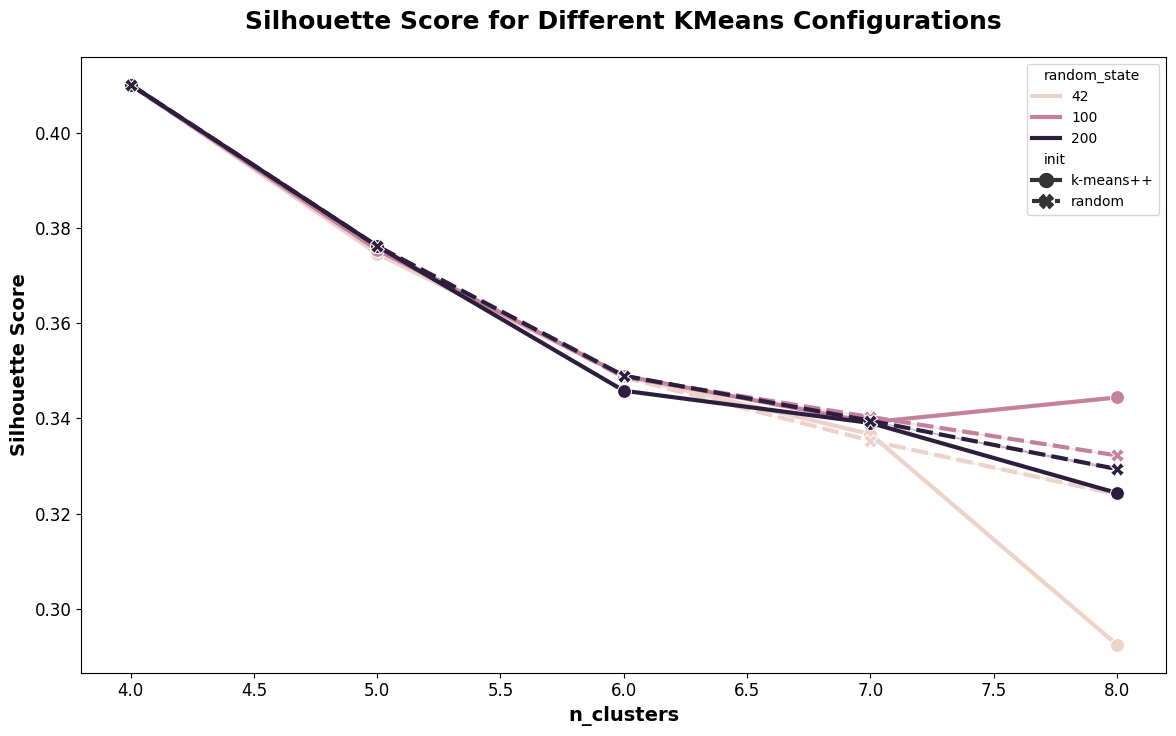

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



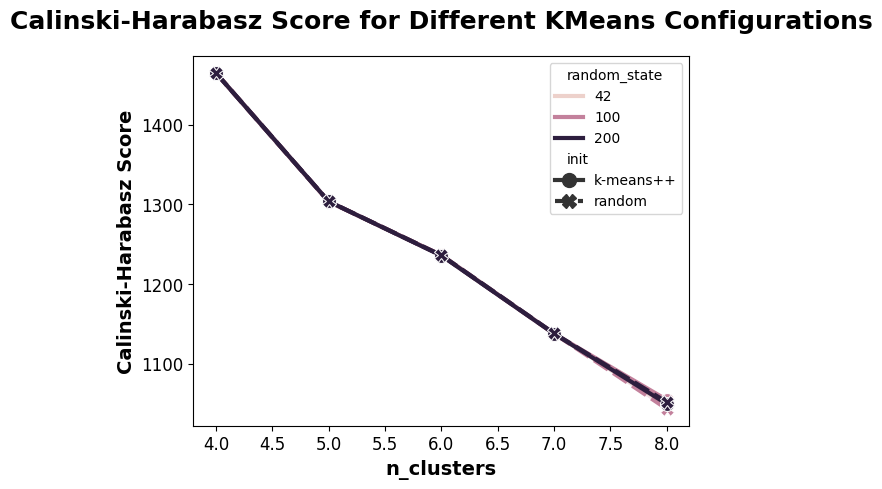

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



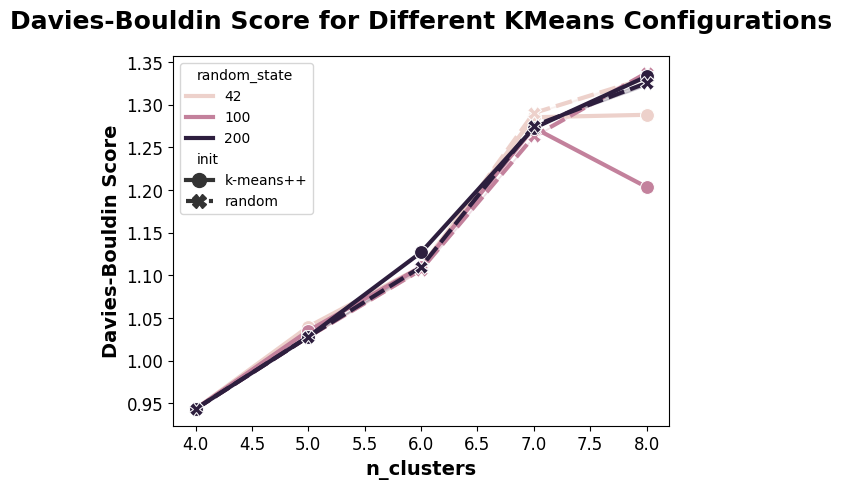

In [14]:
# ==================================================================
# SENSITIVITY ANALYSIS
# =================================================================
from joblib import Parallel, delayed
import numpy as np

def sensitivity_analysis_kmeans(df_scaled, feature_names, cluster_range, random_state_list, additional_params=None, n_jobs=-1):
    """
    Perform sensitivity analysis by varying the number of clusters, random states, and additional parameters for KMeans clustering.
    
    Parameters:
    -----------
    df_scaled : numpy array
        The scaled data to cluster.
    feature_names : list
        List of feature names.
    cluster_range : list
        A list of cluster numbers to try (e.g., [3, 4, 5, 6, 7]).
    random_state_list : list
        A list of random states to try (e.g., [42, 100, 200]).
    additional_params : dict (optional)
        Additional KMeans parameters to vary, such as 'max_iter', 'init', and 'tol'.
    n_jobs : int
        Number of parallel jobs to run (default is -1, meaning all CPUs are used).
    
    Returns:
    --------
    results_df : DataFrame
        A DataFrame containing the results of the sensitivity analysis with columns for each metric.
    """
    results = []

    # Default additional parameters if none are provided
    if additional_params is None:
        additional_params = {'max_iter': [300], 'init': ['k-means++'], 'tol': [1e-4]}
    
    # Define combinations of the additional parameters
    max_iters = additional_params['max_iter']
    inits = additional_params['init']
    tols = additional_params['tol']
    
    def run_kmeans(n_clusters, random_state, max_iter, init, tol):
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, max_iter=max_iter, init=init, tol=tol, n_init = 10)
        labels = kmeans.fit_predict(df_scaled)
        
        silhouette = silhouette_score(df_scaled, labels)
        calinski_harabasz = calinski_harabasz_score(df_scaled, labels)
        davies_bouldin = davies_bouldin_score(df_scaled, labels)
        
        return {
            'n_clusters': n_clusters,
            'random_state': random_state,
            'max_iter': max_iter,
            'init': init,
            'tol': tol,
            'Silhouette Score': silhouette,
            'Calinski-Harabasz Score': calinski_harabasz,
            'Davies-Bouldin Score': davies_bouldin
        }
    
    # Perform parallel computation for each combination
    results = Parallel(n_jobs=n_jobs)(
        delayed(run_kmeans)(n_clusters, random_state, max_iter, init, tol)
        for n_clusters in cluster_range
        for random_state in random_state_list
        for max_iter in max_iters
        for init in inits
        for tol in tols
    )
    
    # Convert results to a DataFrame for easy visualization
    results_df = pd.DataFrame(results)
    
    return results_df

# Define the parameters for sensitivity analysis
cluster_range = [4, 5, 6, 7, 8]
random_state_list = [42, 100, 200]
additional_params = {'max_iter': [300, 500], 'init': ['k-means++', 'random'], 'tol': [1e-4, 1e-3]}

# Run sensitivity analysis
sensitivity_results = sensitivity_analysis_kmeans(df_scaled_selected_KMEANS, features, cluster_range, random_state_list, additional_params)


# Display the results
display(sensitivity_results)

# Plotting results for better insights
plt.figure(figsize=(14, 8))

sns.lineplot(data=sensitivity_results, x='n_clusters', y='Silhouette Score', hue='random_state', style='init', markers=True)
plt.title('Silhouette Score for Different KMeans Configurations')
plt.show()

sns.lineplot(data=sensitivity_results, x='n_clusters', y='Calinski-Harabasz Score', hue='random_state', style='init', markers=True)
plt.title('Calinski-Harabasz Score for Different KMeans Configurations')
plt.show()

sns.lineplot(data=sensitivity_results, x='n_clusters', y='Davies-Bouldin Score', hue='random_state', style='init', markers=True)
plt.title('Davies-Bouldin Score for Different KMeans Configurations')
plt.show()


# V. Clusters Interpretation and visualization

In [16]:
# Remove unnecessary columns
df = df.drop(columns=['ID', 'Dt_Customer'])
df = df.drop(columns=['Hierarchical_Cluster'])


In [17]:
# ==================================================================
# SUMMARIZE EACH CLUSTER'S CHARACTERISTICS
# =================================================================
# Group by 'Cluster' and calculate summary statistics
cluster_summary = df.groupby('Cluster').mean()
display(cluster_summary)

/tmp/ipykernel_1149/372030437.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Age_Squared,TotalChildren,HasChildren,ChildrenRatio,TotalSpending,TotalAcceptedCampaigns,MntWines_Ratio,MntFruits_Ratio,MntMeatProducts_Ratio,MntFishProducts_Ratio,MntSweetProducts_Ratio,MntGoldProds_Ratio,AvgSpendingPerProduct,SpendingVariance,SpendingSkew,LuxuryRatio,FreshFoodRatio,Income_Log,SpendingToIncome,AvgTransactionValue,TotalPurchases,WebPurchaseRatio,CatalogPurchaseRatio,StorePurchaseRatio,ComplaintRate,AcceptanceRate,WebActivityRatio,DaysCustomer,CustomerTenure,PurchaseFrequency,Income_Age_Interaction,Income_Children_Interaction,Age_Children_Interaction,CustomerLifetimeValue,EngagementScore,WinePreference,GoldPreference,FreshFoodPreference
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1965.69,2.47,3.72,44424.77,1.07e+00,1.04,50.52,127.46,7.34,50.65,10.36,7.76,23.91,3.57,3.13,0.99,4.09,6.35,0.07,0.04,7.01e-03,9.35e-03,4.67e-03,1.64e-02,3.0,11.0,0.11,57.31,3359.01,2.11e+00,1.00e+00,5.06e-01,227.49,0.23,0.53,0.03,0.23,0.05,0.03,0.14,37.92,7671.80,1.41,0.66,0.30,10.64,4.43e-03,21048.28,8.21,0.35,0.10,0.55,2.66e-03,0.04,44393.60,1.38e+09,363.79,0.10,2.54e+06,93898.02,121.12,3.58,11098.47,127.46,23.91,68.36
1,1970.97,2.35,3.78,76176.41,2.82e-03,0.00,50.49,629.83,65.46,492.03,96.17,65.92,77.17,1.07,4.83,6.41,8.91,2.59,0.09,0.14,2.96e-01,2.39e-01,4.23e-02,5.63e-03,3.0,11.0,0.32,52.03,2864.60,2.82e-03,2.82e-03,2.82e-03,1426.59,1.12,0.43,0.05,0.34,0.07,0.05,0.06,237.77,93063.60,1.32,0.49,0.46,11.22,2.07e-02,72.44,20.15,0.24,0.32,0.44,2.27e-04,0.19,0.13,1.37e+09,337.15,0.23,3.97e+06,6.89,0.12,18.11,0.24,629.83,77.17,653.66
2,1965.37,2.51,3.67,59478.48,5.48e-02,0.97,48.38,449.59,28.82,145.80,40.39,30.56,58.12,2.78,5.68,3.33,7.56,5.21,0.06,0.13,3.54e-02,4.19e-02,1.61e-02,6.44e-03,3.0,11.0,0.08,57.63,3398.77,1.02e+00,1.00e+00,5.48e-02,753.28,0.36,0.60,0.04,0.19,0.05,0.04,0.09,125.55,45078.10,1.76,0.69,0.27,10.97,1.20e-02,42.25,16.56,0.34,0.19,0.47,3.76e-04,0.06,0.39,1.37e+09,327.70,0.17,3.42e+06,60945.90,59.01,9.88,0.24,449.59,58.12,215.01
3,1972.34,2.15,3.65,44599.19,0.00e+00,0.00,47.45,222.49,31.85,169.37,42.89,32.42,46.10,1.30,3.44,1.83,4.41,5.20,0.05,0.03,7.32e-02,6.34e-02,1.46e-02,4.88e-03,3.0,11.0,0.19,50.66,2734.20,0.00e+00,0.00e+00,0.00e+00,545.11,0.43,0.30,0.08,0.26,0.12,0.08,0.16,90.85,25384.48,1.02,0.46,0.46,10.52,9.74e-03,68337.37,9.68,0.33,0.16,0.50,1.63e-03,0.07,165854.53,1.37e+09,348.81,0.07,2.28e+06,0.00,0.00,4.23,41463.73,222.49,46.10,244.10
4,1977.96,2.14,3.71,30675.20,9.57e-01,0.06,48.93,39.58,7.55,31.82,10.24,7.04,18.59,2.08,2.45,0.53,3.20,6.90,0.09,0.00,0.00e+00,0.00e+00,0.00e+00,1.02e-02,3.0,11.0,0.12,45.04,2077.96,1.02e+00,1.00e+00,9.46e-01,114.81,0.22,0.29,0.07,0.27,0.10,0.07,0.19,19.14,1089.78,0.84,0.48,0.45,10.25,3.63e-03,10198.11,6.19,0.36,0.07,0.56,2.35e-03,0.04,28514.62,1.37e+09,351.37,0.06,1.39e+06,31022.59,45.91,1.68,7128.71,39.58,18.59,49.60


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning:

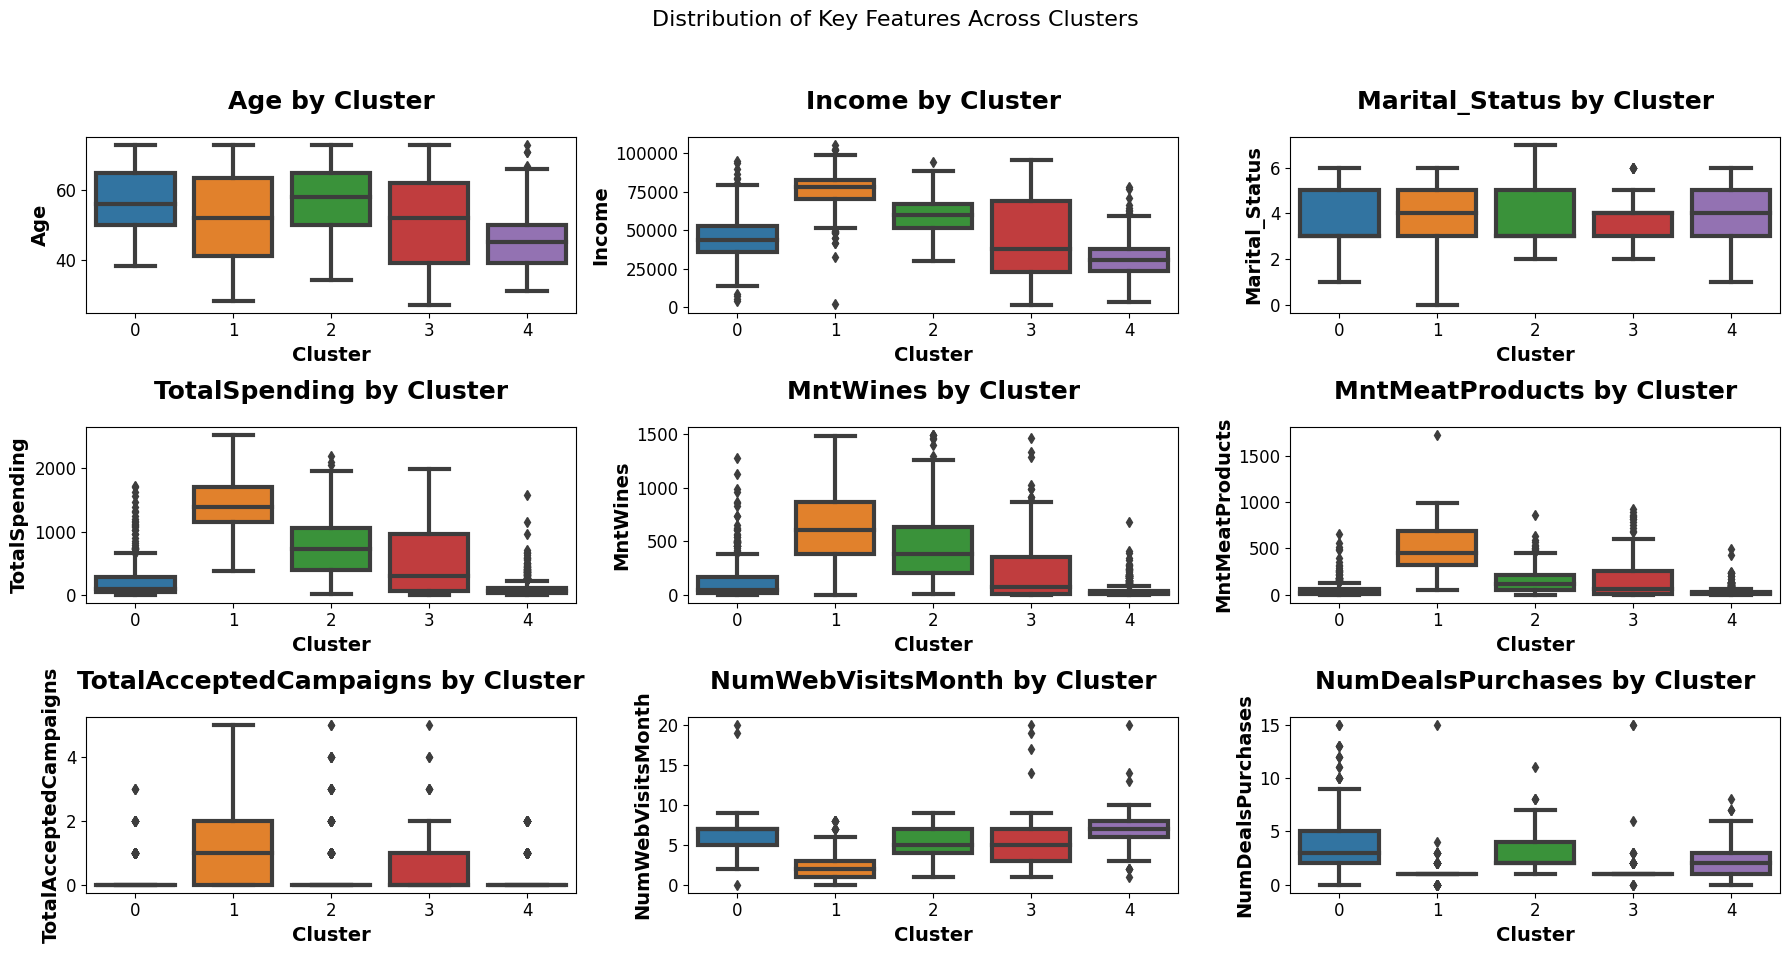

In [18]:
# ==================================================================
# COMPARE KEY FEATURES ACROSS CLUSTERS
# =================================================================
# Set up a 3x3 grid for subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
fig.suptitle('Distribution of Key Features Across Clusters', fontsize=16)

# List of features to plot
features = ['Age', 'Income', 'Marital_Status', # Demographic Features
            'TotalSpending', 'MntWines', 'MntMeatProducts', # Spending Patterns 
            'TotalAcceptedCampaigns', 'NumWebVisitsMonth', 'NumDealsPurchases' # Engagement with Campaigns
           ]

'''
1. Demographic Features
- Age: To observe if certain age groups are concentrated within specific clusters.
- Income: To check for income-based segmentation.
- Marital_Status: This could indicate family-oriented vs. single customer profiles.

2. Spending Patterns
- TotalSpending: Gives an overall view of spending behavior across clusters.
- MntWines, MntMeatProducts, MntGoldProds: These represent preferences in spending categories (e.g., luxury, essentials).

3. Engagement and Campaign Acceptance
- TotalAcceptedCampaigns: Indicates how responsive each cluster is to marketing campaigns.
- NumWebVisitsMonth: Shows how often customers visit the website, potentially indicating engagement level.
- NumDealsPurchases: Reflects interest in promotions.
'''
# Loop over each feature and create a box plot in the corresponding subplot
for i, feature in enumerate(features):
    sns.boxplot(data=df, x='Cluster', y=feature, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f'{feature} by Cluster')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/cond

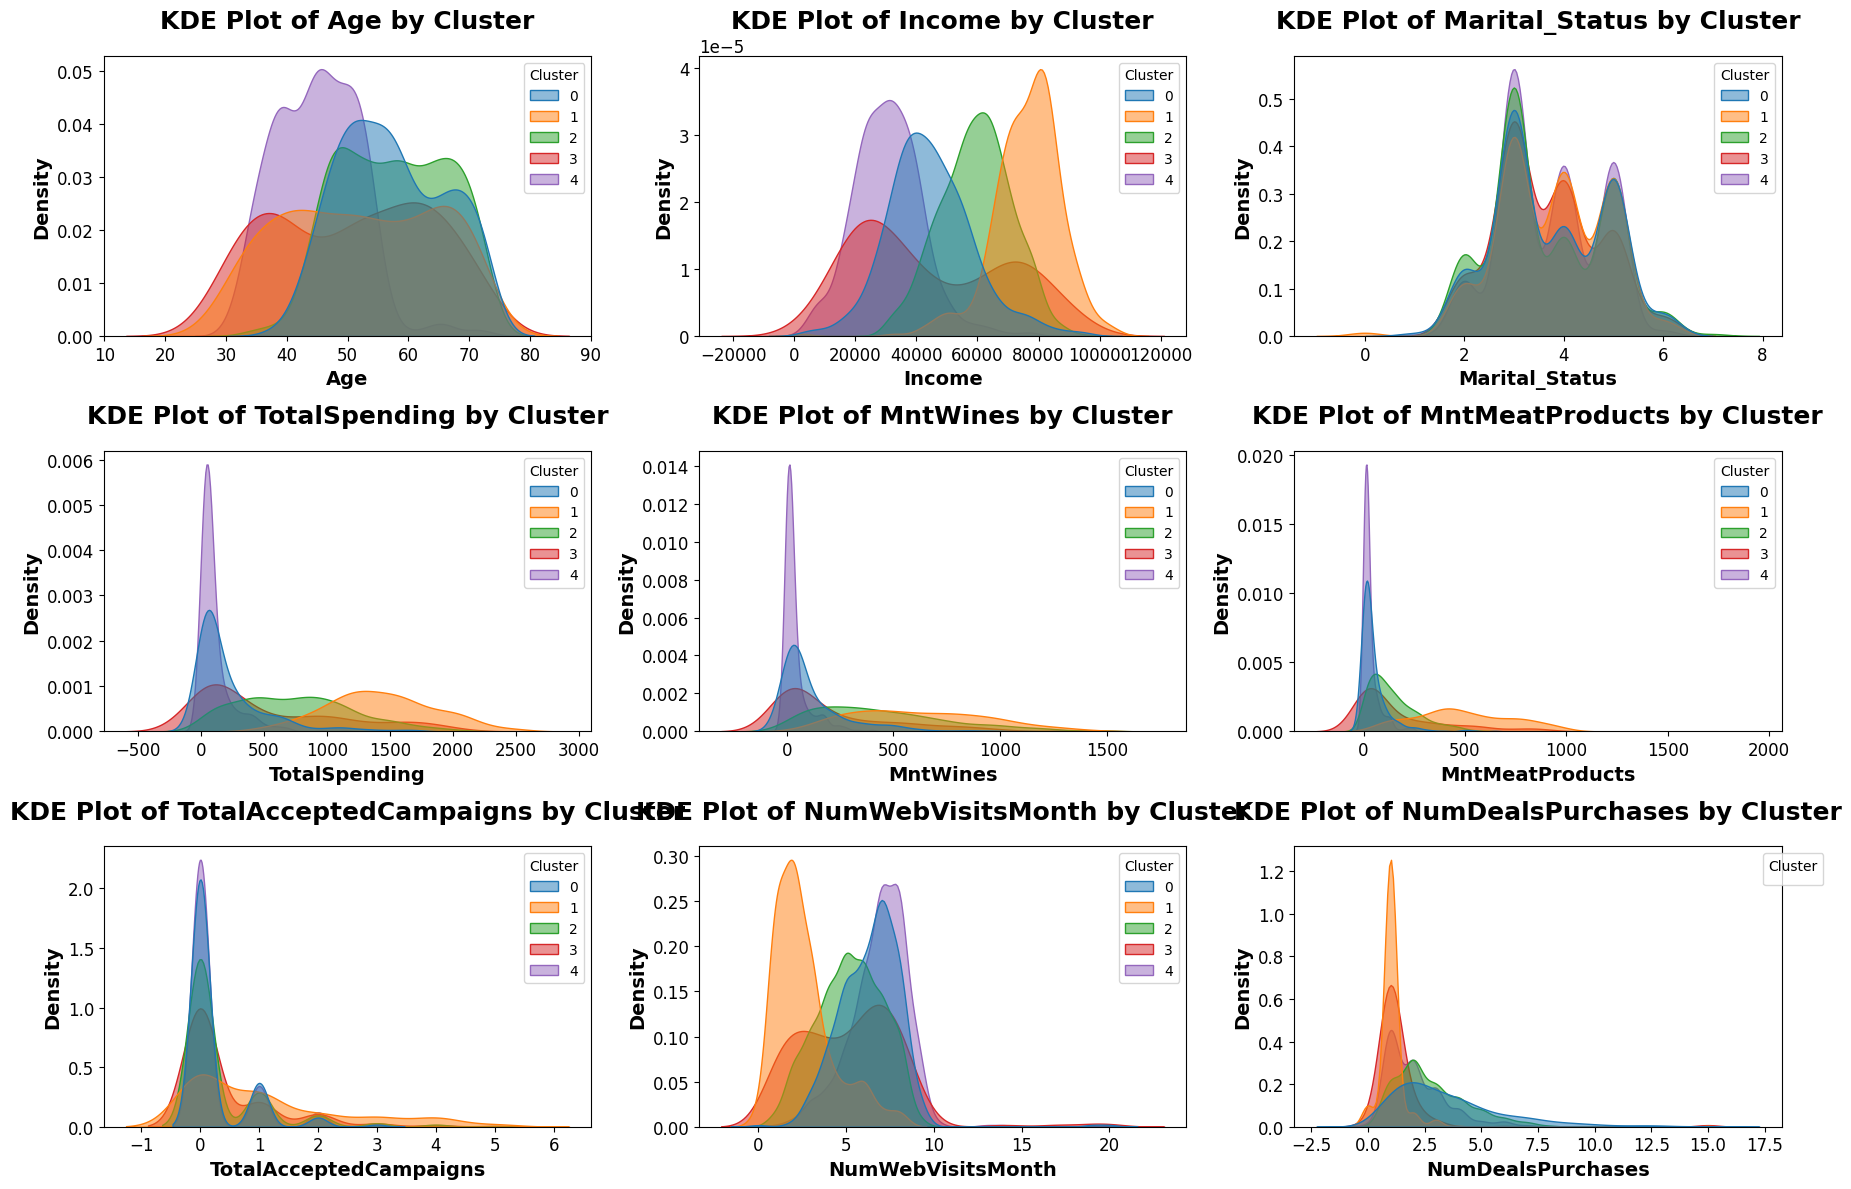

In [19]:
# Set up the matplotlib figure
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

# Create KDE plots for each feature by Cluster
for i, feature in enumerate(features):
    sns.kdeplot(data=df, x=feature, hue='Cluster', fill=True, ax=axes[i], common_norm=False, alpha=0.5)
    axes[i].set_title(f'KDE Plot of {feature} by Cluster')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning:

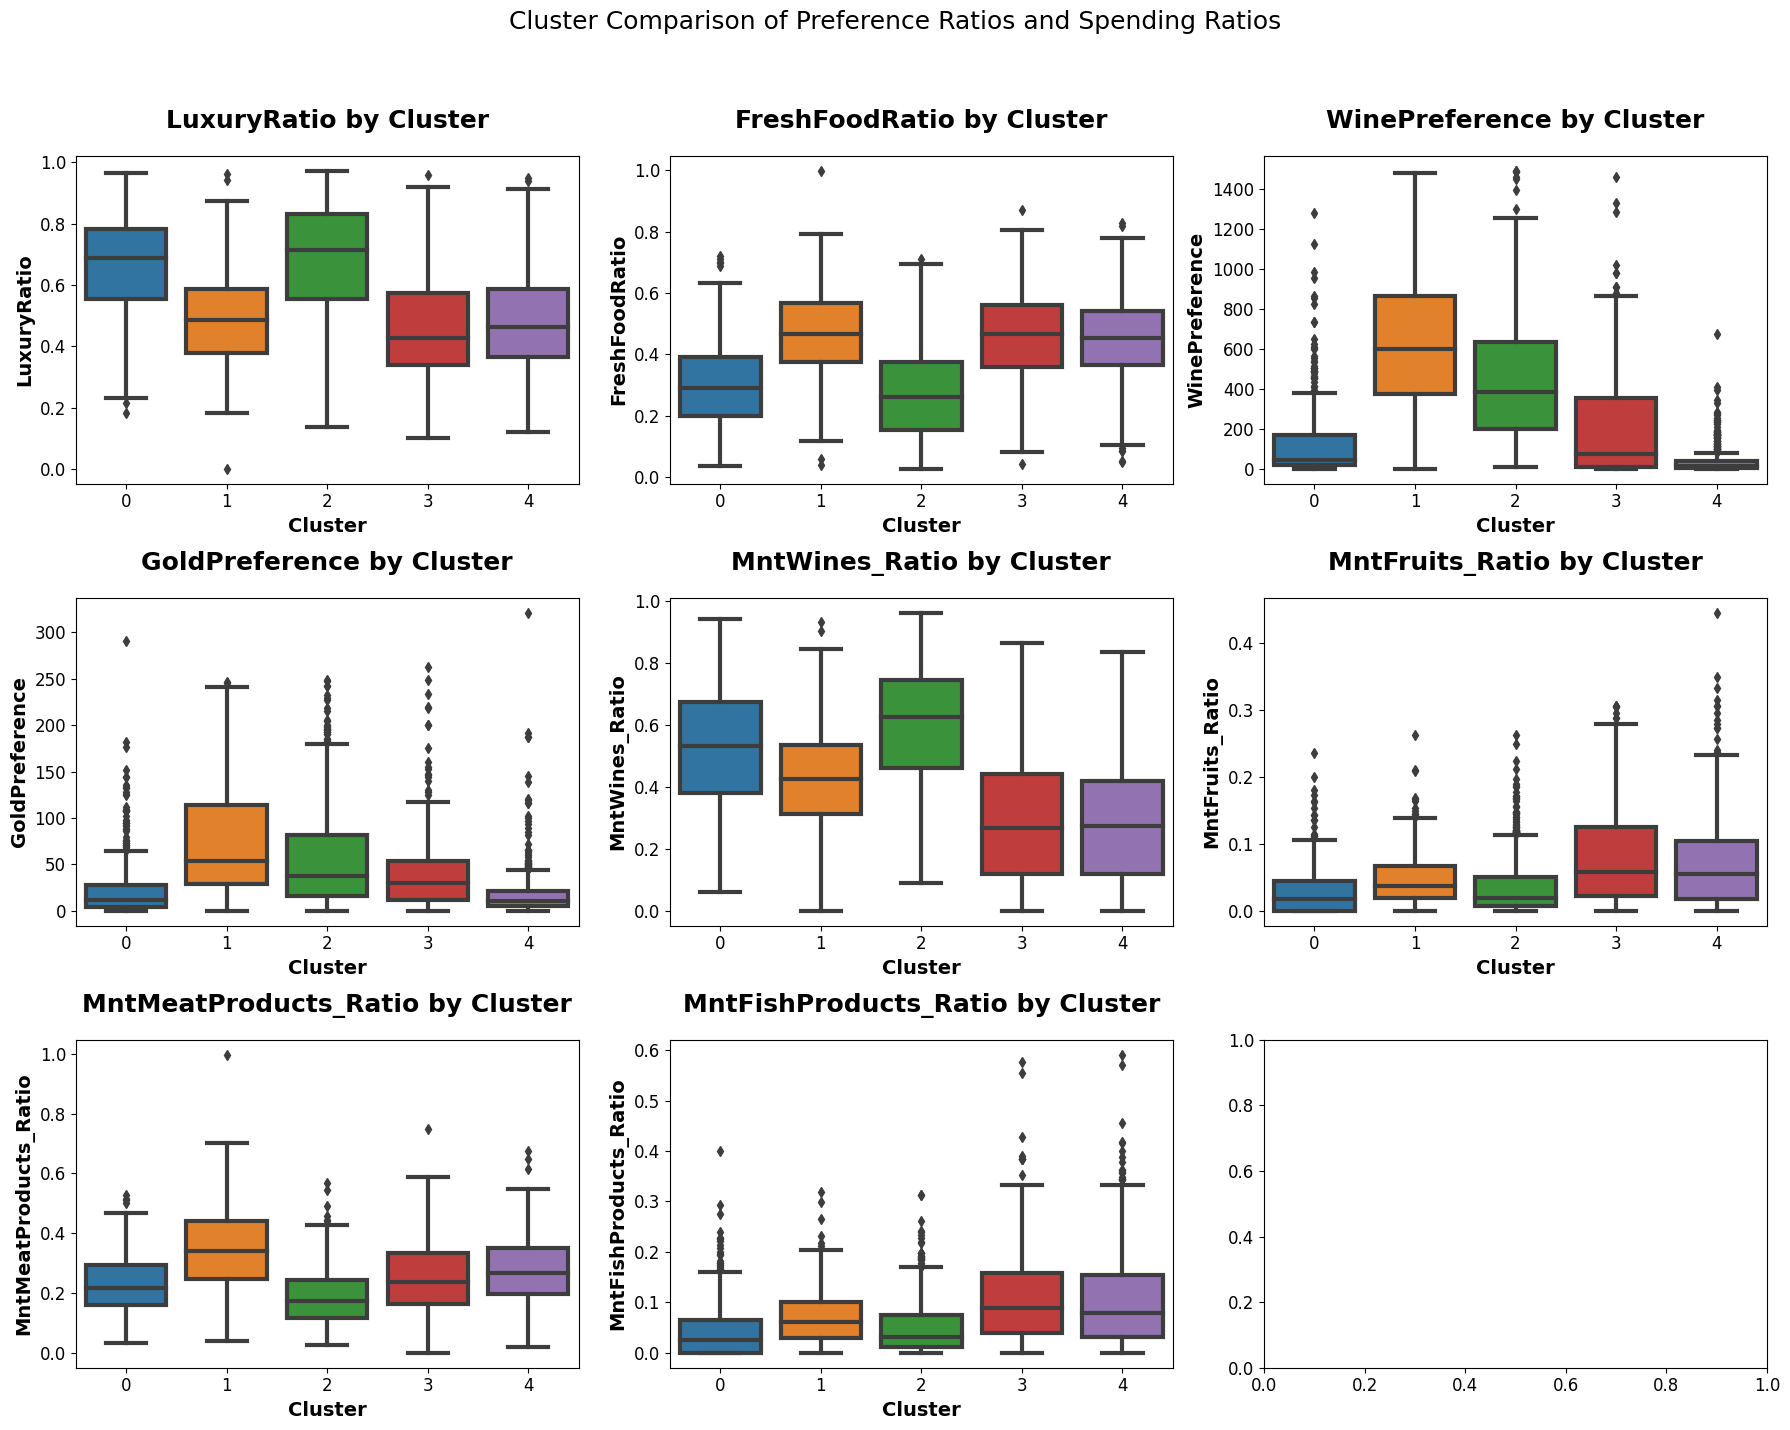

In [20]:
# ==================================================================
# RATIOS AND PREFERENCES IN EACH CLUSTER
# BOXPLOT
# =================================================================
# Define the features to analyze for preferences and ratios
preference_features = ['LuxuryRatio', 'FreshFoodRatio', 'WinePreference', 
                       'GoldPreference', 'MntWines_Ratio', 'MntFruits_Ratio', 
                       'MntMeatProducts_Ratio', 'MntFishProducts_Ratio']

# Set up a grid for subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Cluster Comparison of Preference Ratios and Spending Ratios', fontsize=18)

# Plot each feature in a separate subplot
for i, feature in enumerate(preference_features):
    sns.boxplot(data=df, x='Cluster', y=feature, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f'{feature} by Cluster')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/cond

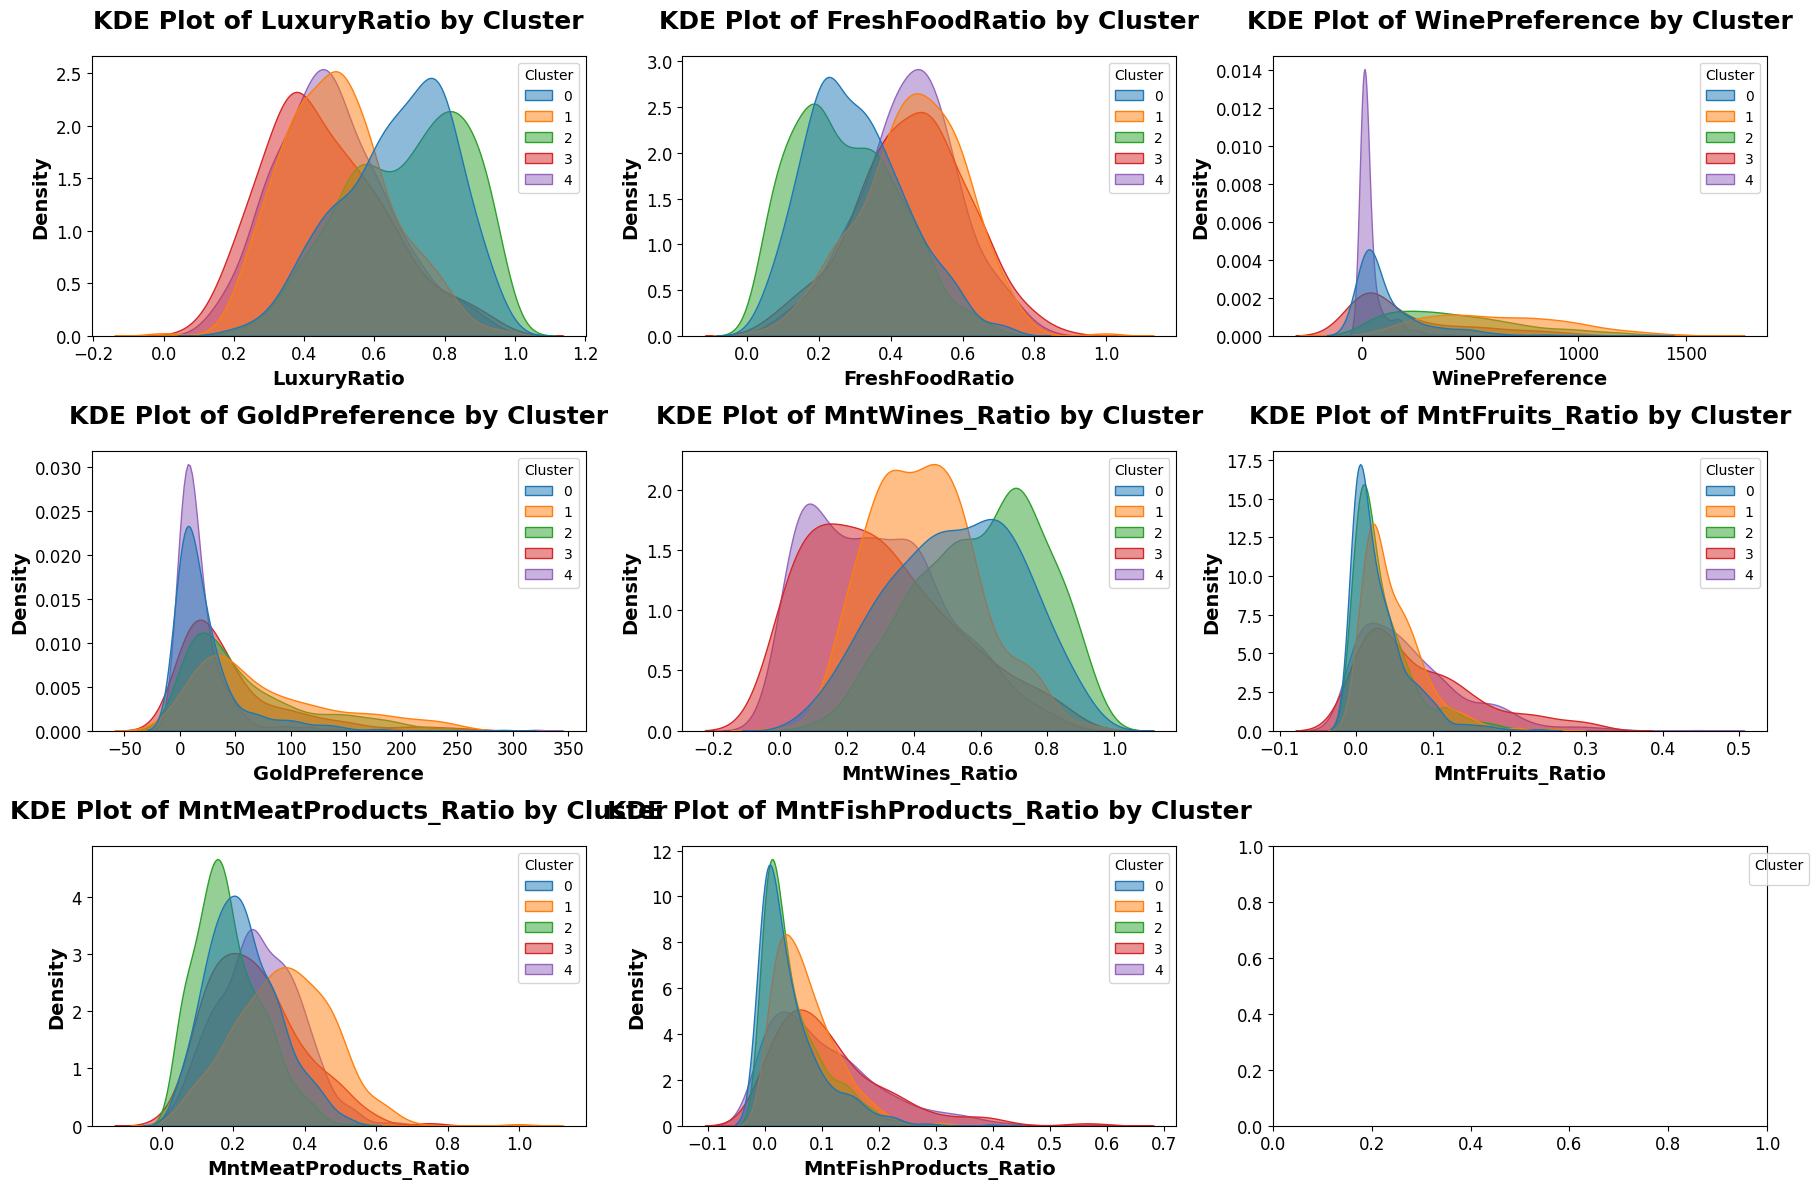

In [21]:
# ==================================================================
# RATIOS AND PREFERENCES IN EACH CLUSTER
# KDE
# =================================================================
# Set up the matplotlib figure
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

# List of preference features to plot
preference_features = ['LuxuryRatio', 'FreshFoodRatio', 'WinePreference', 
                       'GoldPreference', 'MntWines_Ratio', 'MntFruits_Ratio', 
                       'MntMeatProducts_Ratio', 'MntFishProducts_Ratio']

# Create KDE plots for each feature by Cluster
for i, feature in enumerate(preference_features):
    if i >= len(axes):  # Stop if we exceed the number of axes
        break
    sns.kdeplot(data=df, x=feature, hue='Cluster', fill=True, ax=axes[i], common_norm=False, alpha=0.5)
    axes[i].set_title(f'KDE Plot of {feature} by Cluster')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

In [22]:
# ==================================================================
# PROFILE FOR EACH CLUSTER
# =================================================================

<div style="background-color:#b6d7a8; padding: 15px;">
    
## NOTE 6 : Cluster Summary, Definitions and Strategic Recommendations

| Cluster | Age (Years) | Income (Dollar) | Children | Customer Lifetime Value  | Engagement Score | Total Spending (Dollar) | Wines (Dollar) | Fruits (Dollar) | Meat (Dollar) | Fish (Dollar) |
|---------|-------------|-----------------|----------|--------------------------|------------------|-------------------------|----------------|-------------|----------|----------|
| **0**   | ~57         | 44,424.77       | 2        | 3.58                     | 11,098.47        | 227.49                  | 127.46         | 7.34        | 50.65    | 10.36    |
| **1**   | ~53         | 76,176.41       | 0        | 18.11                    | 0.24             | 1426.59                 | 629.83         | 65.46       | 492.03   | 96.17    |
| **2**   | ~58         | 59,478.48       | 1        | 9.88                     | 0.24             | 753.28                  | 449.59         | 28.82       | 145.80   | 40.39    |
| **3**   | ~51         | 44,599.19       | 0        | 4.23                     | 41,463.73        | 545.11                  | 222.49         | 31.85       | 169.37   | 42.89    |
| **4**   | ~45         | 30,675.20       | 1        | 1.68                     | 7,128.71         | 114.81                  | 39.58          | 7.55        | 31.82    | 10.24    |

### Cluster Definitions

| Cluster | Definition | Description | 
|---------|------------|-------------|
| **0**   | **Moderate Spenders with Average Engagement** |  Customers in this cluster are around 57 years old and have moderate income. They have 2 children and show a decent engagement score, indicating some loyalty. Their total spending is average, suggesting they are regular customers but may not be the most enthusiastic. |
| **1**   | **High Income, Low Engagement** | This group consists of relatively younger customers (~53 years) with a high income and no children. Despite their significant spending, their engagement score is low, indicating they may not be fully connected to the brand. Targeted marketing strategies could help increase their engagement. |
| **2**   | **Older Moderate Spenders with Low Engagement** | Customers in this cluster are around 58 years old with moderate income. They have one child and a low engagement score, reflecting a lack of interaction with the brand. Their spending indicates they are somewhat invested, but there’s potential for growth in engagement. |
| **3**   | **Highly Engaged Moderate Spenders** | This cluster consists of 51-year-old customers with moderate income and no children. They exhibit a high engagement score, suggesting strong brand loyalty. Their total spending is higher than average, indicating they are valuable customers who respond well to marketing efforts. |
| **4**   | **Low Income, Low Engagement Families** | Customers in this cluster are around 45 years old and have low income. They have one child and a relatively low engagement score. Their spending is the least among all clusters, indicating they may need re-engagement campaigns and targeted promotions to increase their loyalty and spending. |


### Strategic Recommendations
1. **Increase Engagement:** Focus marketing efforts on Clusters 1 and 3, which show potential for higher engagement.
2. **Target High Engagement with Low Spending:** Cluster 3 has a high engagement score but low spending; develop campaigns to encourage spending.
3. **Re-engagement Campaigns:** Investigate and motivate Cluster 4 to increase their engagement and spending.
4. **Tailor Marketing Campaigns:** Use spending insights to create personalized offers that cater to the specific preferences of each cluster.
    
</div>


In [23]:
# ==================================================================
# CUSTOMER LIFETIME VALUE AND ENGAGEMENT
# =================================================================

# Calculate average Customer Lifetime Value and Engagement Score by Cluster
clv_engagement_summary = df.groupby('Cluster')[['CustomerLifetimeValue', 'EngagementScore']].mean().reset_index()

# Display the summary
display(clv_engagement_summary)

/tmp/ipykernel_1149/3445417893.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,Cluster,CustomerLifetimeValue,EngagementScore
0,0,3.58,11098.47
1,1,18.11,0.24
2,2,9.88,0.24
3,3,4.23,41463.73
4,4,1.68,7128.71
